# EDA - HealthGuard Insurance Cross-Sell 

## Contextualization

Our client, an insurance company, is seeking our assistance in creating a predictive model to determine the likelihood of policyholders from the previous year being interested in the company's vehicle insurance. 

Insurance policies involve an agreement in which an insurance company guarantees compensation for specific losses, damages, illnesses, or death in exchange for regular premium payments. For instance, customers may pay an annual premium of $5000 to receive health insurance coverage worth $200.000. If a customer becomes ill and requires hospitalization, the insurance provider will cover the cost of hospitalization up to Rs. $200.000. This concept relies on probabilities, as only a few customers will require hospitalization each year out of a larger pool of premium-paying customers.

Similarly, vehicle insurance requires customers to pay an annual premium to an insurance provider. In case of an unfortunate accident, the insurance provider will compensate the customer with a compensation called 'sum assured'. 

Predicting a customer's interest in vehicle insurance is crucial for the company to optimize its business model and revenue.

## Business Problem
1. The product team is seeking to create a predictive tool capable of identifying, in a database of 127,000 customers, those with the highest likelihood of joining the new premium health/automobile insurance plan. This is because the plan enrollment will be done through direct contact by the sales team, via phone calls, with only 2000 calls available to contact customers.

2. It is important to note that the tool needs to have a minimum accuracy of 80% to ensure profitability for the company in the creation of the new plan.

## Solution Planning

- **Data exploration:** Explore the data to understand its features, identify any missing values or outliers, and clean the data if necessary.
- **Raise hypotheses:** Create and validate hypotheses in search of correlations that may be useful for the machine learning model and also help identify possible insights that may be useful to the business team.
- **Feature engineering:** We need to create new features or transform existing features to help the model learn patterns and make better predictions.
- **Model selection:** We need to select an appropriate machine learning model that can handle the problem and the data.
- **Model training and evaluation:** We need to train the model on a training set and evaluate its performance on a validationset using appropriate metrics such as accuracy, precision, recall, and F1 score.
- **Hyperparameter tuning:** We need to tune the hyperparameters of the model to optimize its performance.
- **Model deployment:** We need to deploy the model to production and integrate it with the company's systems.

# 0.0. Imports, Functions, Settings and Data Loading

## 0.1. Imports

In [190]:
import sys
import inflection

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from PIL                   import Image
from IPython.core.display  import HTML

from scipy                 import stats  as ss
from matplotlib            import pyplot as plt



from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier 


## 0.2. Functions

In [4]:

def get_percentage(value, total):         
    return round( ( value * 100 ) / total, 2 )

def cramer_v_bias_correction(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
    """
    
    confusion_matrix = pd.crosstab(x, y).values
    
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 8]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()



#============================================================
#           HELPER FUNCTIONS
#============================================================

#Rename Dataframe Columns to snanakecase
def change_columns(columns):
    """
    Rename a list of values to columns name in Dataframe to snakecase format.
    
    Examples: 
    Old Columns: 'DayOfWeek', 'Date', 'Sales'
    Return: 'day_of_week', 'date', 'sales'
        
    Old Columns: 'Day_Of_Week', 'StoreType', 'Sales'
    Return: 'day_of_week', 'store_type', 'sales'
    
    """
    cols_old = columns
    snakecase = lambda x: inflection.underscore( x )

    cols_new = list( map( snakecase, cols_old ) )
    
    return cols_new

def get_numerical_descriptive_statistic(numerical_attributes):
    # Measures of central tendency (mean and median)
    t1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    t2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # Dispersion measure - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T
    d2 = pd.DataFrame( numerical_attributes.apply( np.min ) ).T
    d3 = pd.DataFrame( numerical_attributes.apply( np.max ) ).T
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T

    #concat
    m1 = pd.concat( [ d2, d3, d4, t1, t2, d1, d5, d6 ] ).T.reset_index()
    m1.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m1

def plot_skew_kurtosis(df, fig_size=(12,6)):
    """
    Plots skewness and kurtosis for each column in a dataframe.
    """
    ncols = df.shape[1]
    nrows = int(np.ceil(ncols/2))
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=fig_size)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        data = df[col].dropna()
        skewness = data.skew()
        kurtosis = data.kurtosis()
        num_bins = int(np.ceil(np.log2(len(data))) + 1)

        # Plotting the histogram
        axes[i].hist(data, bins=num_bins)
        axes[i].set_title(f"{col}\nSkewness={skewness:.2f}, Kurtosis={kurtosis:.2f}")        

    # Adding a title to the plot
    fig.suptitle('Categorical Variables')

    plt.show()
    
    
def compute_precision_recall_at_k( y_true, y_pred_proba, k):
    """
    Computes the precision and recall at a given k value for a binary classification model.

    Args:
        data (pandas DataFrame): The data used for prediction.
        y_true (pandas Series): The ground truth labels.
        y_pred_proba (numpy ndarray): The predicted probabilities for the positive class.
        k (int): The value of k for computing the metrics.

    Returns:
        A tuple with the precision and recall values at k
    """
    # Create a DataFrame with the prediction and ground truth labels, sorted by the predicted probabilities
    df = pd.DataFrame({
        'y_true': y_true.values,
        'y_pred_proba': y_pred_proba
    }).sort_values('y_pred_proba', ascending=False)

    # Compute the cumulative sum of true positives and total predictions up to k
    df['tp_at_k'] = df['y_true'].cumsum()
    df['pred_at_k'] = df.index + 1

    # Compute precision and recall at k
    precision_at_k = df.loc[df['pred_at_k'] == k, 'tp_at_k'].sum() / k
    recall_at_k = df.loc[df['pred_at_k'] == k, 'tp_at_k'].sum() / df['y_true'].sum()

    return precision_at_k, recall_at_k  

def cross_validation(model_name, model, x, y, k=20000, n_splits=5, random_state=28):
    """
    Computes the average precision and recall at a given k value for a binary classification model using
    k-fold cross-validation.
    
    Parameters:
    model_name (str): name of the model for identification purposes
    model (sklearn estimator): binary classification model with predict_proba method
    x (pd.DataFrame): features DataFrame
    y (pd.Series): target Series
    k (int): threshold value to compute precision and recall at k (default 20000)
    n_splits (int): number of splits for cross-validation (default 5)
    random_state (int): random state for reproducibility (default 28)
    
    Returns:
    pd.DataFrame: DataFrame with the mean and standard deviation of the precision and recall at k values
    """
    
    precision_at_k_list = []
    recall_at_k_list = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for train_index, test_index in skf.split(x, y):
        
        x_train_cv = x.iloc[train_index]
        y_train_cv = y.iloc[train_index]
        
        x_test_cv = x.iloc[test_index]
        y_test_cv = y.iloc[test_index]
        
        model.fit(x_train_cv, y_train_cv)
        pred_proba = model.predict_proba(x_test_cv)
        
        precision, recall = compute_precision_recall_at_k(y_test_cv, pred_proba[:, 1], k=k)
        
        precision_at_k_list.append(precision)
        recall_at_k_list.append(recall)
        
    
    precision_at_k_mean, precision_at_k_std = np.round(np.mean(precision_at_k_list), 2), np.round(np.std(precision_at_k_list), 2)
    recall_at_k_mean, recall_at_k_std = np.round(np.mean(recall_at_k_list), 2), np.round(np.std(recall_at_k_list), 2)
    
    return pd.DataFrame({
        "Precision@{}".format(k): "{} +/- {}".format(precision_at_k_mean, precision_at_k_std),
        "Recall@{}".format(k): "{} +/- {}".format(recall_at_k_mean, recall_at_k_std)
    }, index=[model_name])


## 0.3 Settings

In [5]:
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.2f' % x)

jupyter_settings()

root_path = sys.path[0]

## 0.4. Data Loading

In [6]:
df_raw         = pd.read_csv( root_path+'/repos/dataset/healthguard_customers.csv', low_memory=False )
df_potencial   = pd.read_csv( root_path+'/repos/dataset/potencial_customers.csv', low_memory=False )

# 1.0. Data Exploration

In [7]:
df1 = df_raw.copy()
df1.columns = change_columns(df1.columns)
df_potencial.columns = change_columns(df_potencial.columns)

## 1.1. Data Description



- **Id:** Unique ID for each customer.
- **Gender:** Gender of the customer.
- **Age:** Age of the customer.
- **Driving License:** 0: Customer does not have DL, 1: Customer already has DL.
- **Region Code:** Unique code for the region of the customer.
- **Previously Insured:** 1: Customer already has Vehicle Insurance, 0: Customer doesn't.
- **Vehicle Age:** Age of the Vehicle.
- **Vehicle Damage:** 1: Customer got his/her vehicle damaged in the past, 0: Customer didn't get his/her vehicle damaged in the past.
- **Anual Premium:** The amount customer needs to pay as premium in the year.
- **Policy sales channel:** Anonymized Code for the channel of outreaching to the customer, i.e., Different Agents, Over Mail, Over Phone, In Person, etc.
- **Vintage:** Number of Days, Customer has been associated with the company.
- **Response:** 1: Customer is interested, 0: Customer is not interested.


### 1.1.1. Dimension

In [8]:
print( 'Dimentions to HealthGuard database ')
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Cols: {df1.shape[1]}' )

print( '\nDimentions to Potencial Primium HealthGuard Customers database ')
print( f'Number of Rows: {df_potencial.shape[0]}' )
print( f'Number of Cols: {df_potencial.shape[1]}' )

Dimentions to HealthGuard database 
Number of Rows: 381109
Number of Cols: 12

Dimentions to Potencial Primium HealthGuard Customers database 
Number of Rows: 127037
Number of Cols: 11


### 1.1.2. Types

The two databases have practically the same information, however the base of potential premium customers does not have the Response column, as this will be the column used in the prediction response.

In [9]:
print( 'Data Types to HealthGuard Customers database ')
df1.dtypes

Data Types to HealthGuard Customers database 


id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [10]:
print( 'Data Types to Potencial Primium HealthGuard Customers database ')
df_potencial.dtypes

Data Types to Potencial Primium HealthGuard Customers database 


id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
dtype: object

### 1.1.3. Missing Values

No missing data in databses. It will not be necessary to clean or delete missing records in both databases.

In [11]:
print( 'Missing Values to HealthGuard Customers database ')
df1.isna().sum()

Missing Values to HealthGuard Customers database 


id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [12]:
print( 'Missing Values to Potencial Primium HealthGuard Customers database ')
df_potencial.isna().sum()

Missing Values to Potencial Primium HealthGuard Customers database 


id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
dtype: int64

### 1.1.4. Change Types

- Changing the values 0 to No and 1 to Yes to help on data analysis.
- Change Float64 type of region_code and policy_sales_channel to int64

In [13]:
dic = {1:'Yes', 0:'No'}

df1['driving_license'] = df1['driving_license'].map(dic)
df1['previously_insured'] = df1['previously_insured'].map(dic)

df1['region_code'] = df1['region_code'].astype('int64')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,Yes,28,No,> 2 Years,Yes,40454.00,26,217,1
1,2,Male,76,Yes,3,No,1-2 Year,No,33536.00,26,183,0
2,3,Male,47,Yes,28,No,> 2 Years,Yes,38294.00,26,27,1
3,4,Male,21,Yes,11,Yes,< 1 Year,No,28619.00,152,203,0
4,5,Female,29,Yes,41,Yes,< 1 Year,No,27496.00,152,39,0


### 1.1.5. Duplicate Values

No duplicate lines in DataFrame

In [14]:
duplicated = df1.duplicated()
print(df1[duplicated])

Empty DataFrame
Columns: [id, gender, age, driving_license, region_code, previously_insured, vehicle_age, vehicle_damage, annual_premium, policy_sales_channel, vintage, response]
Index: []


## 1.2. Descriptive Statistics

### 1.2.1. Numerical Attributes

In [15]:
num_attributes = df1.select_dtypes( include= [ 'int64', 'float64'] )

df_num_desc_staticts = get_numerical_descriptive_statistic(num_attributes)
df_num_desc_staticts

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00,381109.00,381108.00,190555.00,190555.00,110016.69,0.00,-1.20
1,age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57
2,region_code,0.00,52.00,52.00,26.39,28.00,13.23,-0.12,-0.87
3,annual_premium,2630.00,540165.00,537535.00,30564.39,31669.00,17213.13,1.77,34.00
4,policy_sales_channel,1.00,163.00,162.00,112.03,133.00,54.20,-0.90,-0.97
5,vintage,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20
6,response,0.00,1.00,1.00,0.12,0.00,0.33,2.30,3.30


### 1.2.2. Categorical Attributes

In [16]:
cat_attributes = df1.select_dtypes( exclude= [ 'int64', 'float64'] )

cat_attributes.describe()

,gender,driving_license,previously_insured,vehicle_age,vehicle_damage
count,381109,381109,381109,381109,381109
unique,2,2,2,3,2
top,Male,Yes,No,1-2 Year,Yes
freq,206089,380297,206481,200316,192413


# 2.0. Hypotheses

Based on the problem statement, here are some hypotheses that can be explored:

1. Older customers are more likely to be interested in vehicle insurance.
2. Customers who have previously insured their vehicle are less likely to be interested in vehicle insurance as they may already have coverage.
3. Customers who own newer vehicles are more likely to be interested in vehicle insurance as they may have more valuable assets to protect.
4. Customers who have experienced vehicle damage in the past are less likely to be interested in vehicle insurance as they may already have coverage.
5. Customers who have a long association with the insurance company are more likely to be interested in vehicle insurance as they may have a stronger trust relationship with the company.
6. Male customers are more likely to be interested in vehicle insurance as they may be more likely to own and drive vehicles.
7. Customers who have a higher annual premium for their current policy are less likely to be interested in vehicle insurance.
8. Customers who were contacted through certain policy sales channels, such as over the phone or in person, may be more likely to be interested in vehicle insurance compared to those contacted through other channels, such as over mail or email.
9. Regions with the highest percentage of customers tend to have the widest acceptance area for insurance.
10. Customers who do not have a driver's license tend not to adhere to vehicle insurance.
11. There is a greater risk of accidents occurring in customers who are younger.
12. Customers who own vehicles less than a year old cause more accidents.


# 3.0. EDA

In [17]:
df3 = df1.copy()

## 3.1. Univariate Analysis

### 3.1.1. Response Variable

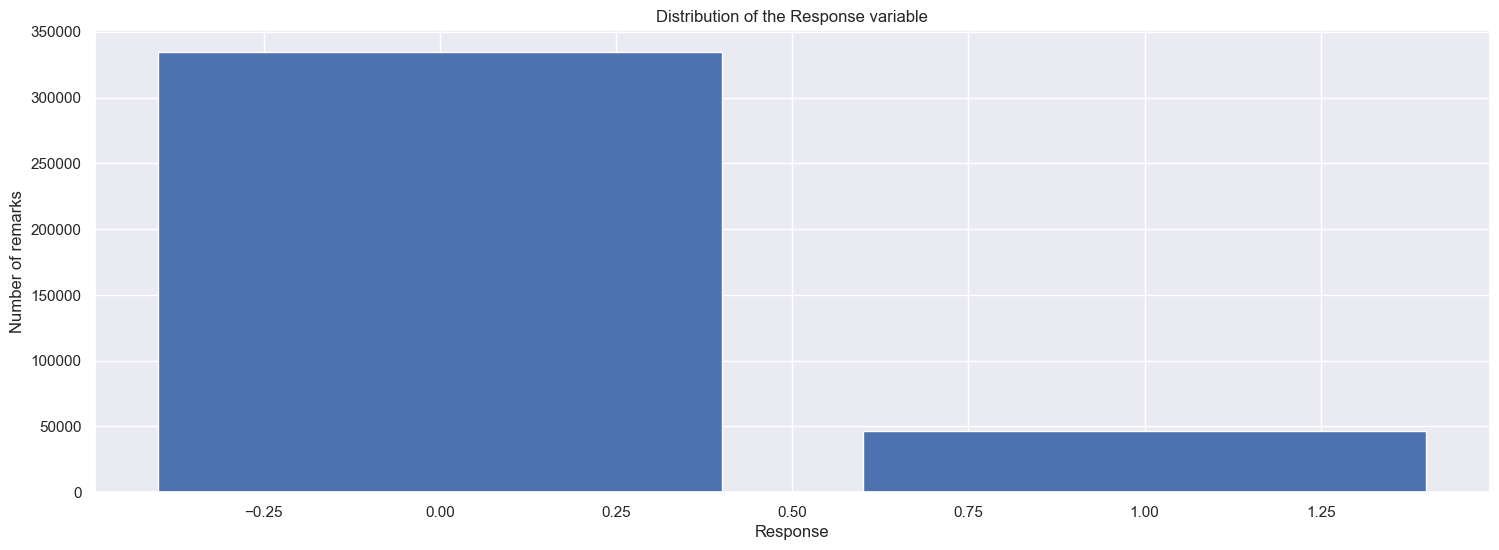

In [18]:
count_response = df3['response'].value_counts()

fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(count_response.index, count_response.values)

ax.set_title('Distribution of the Response variable')
ax.set_xlabel('Response')
ax.set_ylabel('Number of remarks')

plt.show()

### 3.1.2. Numerical Variable

In [19]:
num_attributes[['age', 'region_code', 'annual_premium', 'policy_sales_channel','vintage']].head()

,age,region_code,annual_premium,policy_sales_channel,vintage
0,44,28,40454.00,26,217
1,76,3,33536.00,26,183
2,47,28,38294.00,26,27
3,21,11,28619.00,152,203
4,29,41,27496.00,152,39


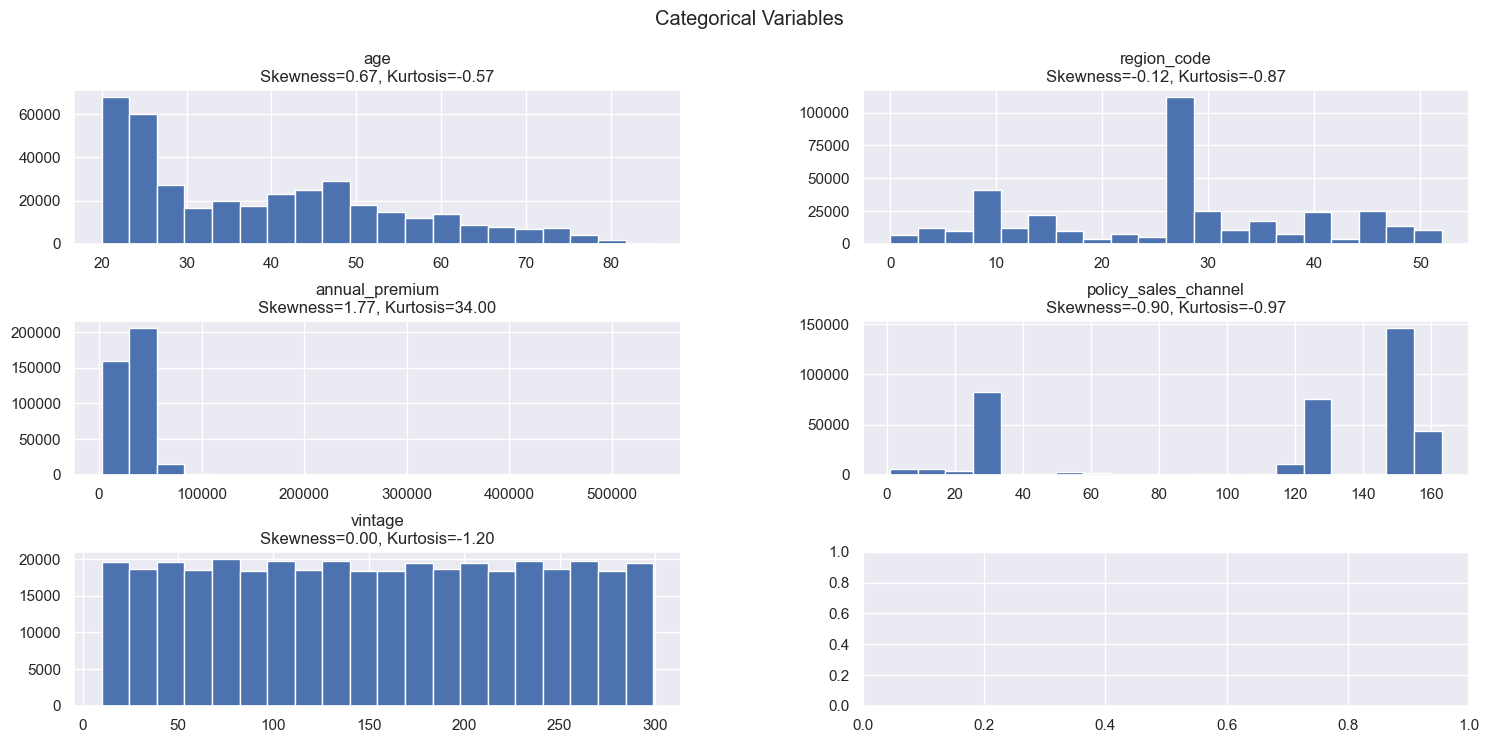

In [20]:
num_col = ['age', 'region_code', 'annual_premium', 'policy_sales_channel','vintage']

plot_skew_kurtosis(num_attributes[num_col], fig_size=(18,8));

### 3.1.3. Categorical Variable

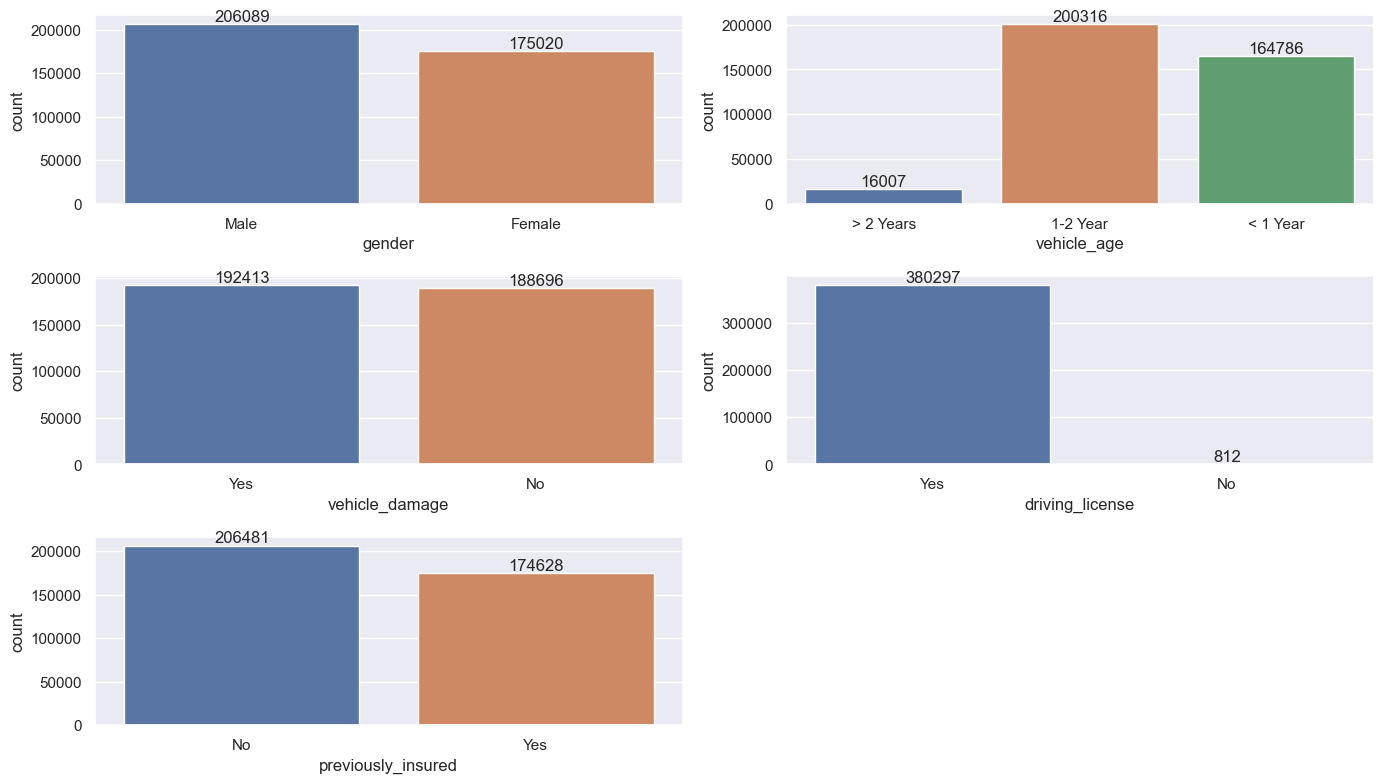

In [21]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

sns.countplot(x='gender', data=cat_attributes, ax=axs[0, 0])
for p in axs[0, 0].patches:
    axs[0, 0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')

sns.countplot(x='vehicle_age', data=cat_attributes, ax=axs[0, 1])
for p in axs[0, 1].patches:
    axs[0, 1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')

sns.countplot(x='vehicle_damage', data=cat_attributes, ax=axs[1, 0])
for p in axs[1, 0].patches:
    axs[1, 0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')

sns.countplot(x='driving_license', data=cat_attributes, ax=axs[1, 1])
for p in axs[1, 1].patches:
    axs[1, 1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')

sns.countplot(x='previously_insured', data=cat_attributes, ax=axs[2, 0])
for p in axs[2, 0].patches:
    axs[2, 0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')

plt.delaxes(axs[2, 1])
plt.tight_layout()
plt.show()

## 3.2. Bivariate Analysis

### 3.2.1. Older customers are more likely to be interested in vehicle insurance.

    The premise is true, but it has some caveats. Customers who are under 31 years old show low interest rates in the plan, whereas those aged between 31 and 50 are more inclined to be interested in it. The interest among customers above 50 years old is still higher than that of the younger group, but it declines over time and nearly matches the interest level of the younger group by the age of 81.

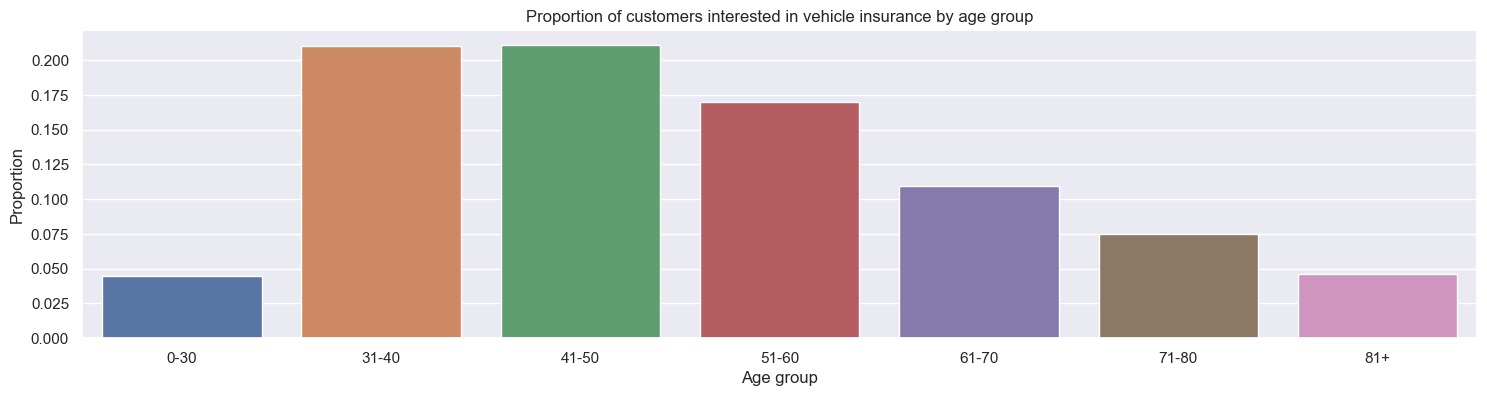

In [22]:
# Make a copy of the original dataframe
df_interested = df3.copy()

# Create a new column with age groups
df_interested['age_group'] = pd.cut(df_interested['age'], bins=[0, 30, 40, 50, 60, 70, 80, 100], labels=['0-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+'])

# Group by age group and calculate the proportion of customers interested in vehicle insurance
df_prop = df_interested.groupby('age_group')['response'].mean().reset_index()


# Plot a bar chart of the proportion of customers interested in vehicle insurance by age group
plt.figure(figsize=(18, 4))
sns.barplot(x='age_group', y='response', data=df_prop)
plt.title('Proportion of customers interested in vehicle insurance by age group')
plt.xlabel('Age group')
plt.ylabel('Proportion')
plt.show()

### 3.2.2. Customers who have previously insured their vehicle are less likely to be interested in vehicle insurance as they may already have coverage.

    The premise is true. Less than 1% of customers who already have car insurance were interested in migrating to new insurance.

df_grouped_excl:
   previously_insured  response
0                 No      0.23
df_grouped_incl:
   previously_insured  response
0                Yes      0.00


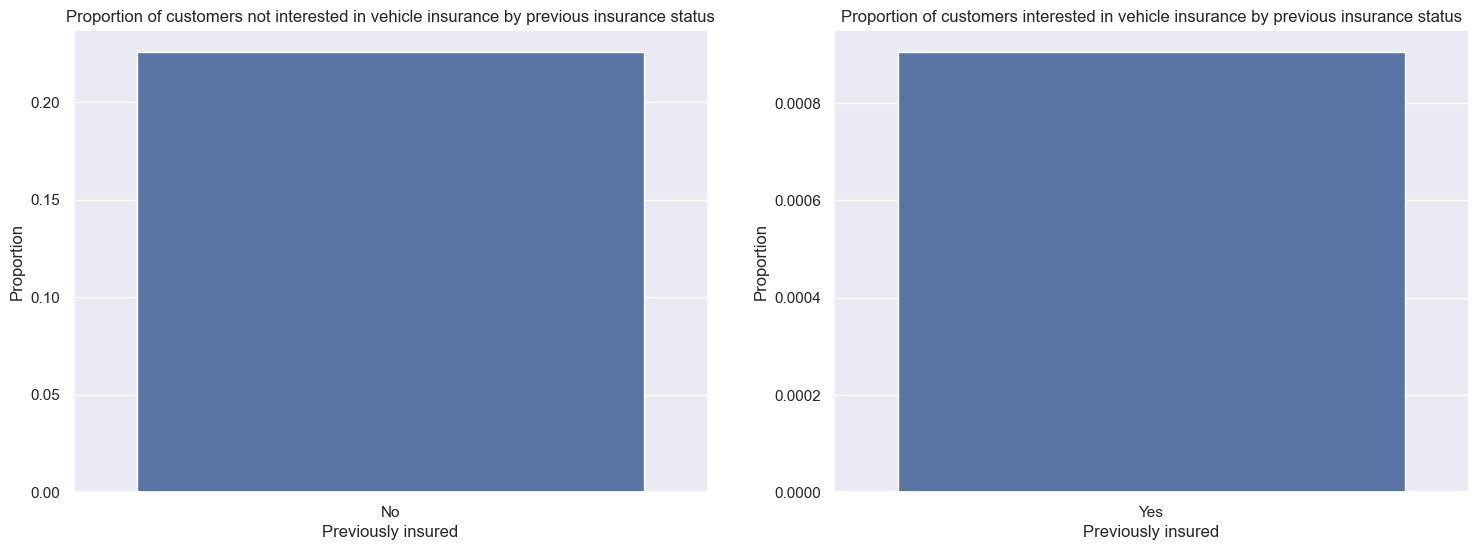

In [23]:
# Create a new dataframe excluding customers who have previously insured their vehicle
df_excl_prev_insured = df3[df3['previously_insured'] == "No"]
# Create a new dataframe including customers who have previously insured their vehicle
df_incl_prev_insured = df3[df3['previously_insured'] == "Yes"]

# Group by the 'previously_insured' column and calculate the proportion of customers not interested in vehicle insurance
df_grouped_excl = df_excl_prev_insured.groupby('previously_insured')['response'].mean().reset_index()
print('df_grouped_excl:\n',df_grouped_excl)
# Group by the 'previously_insured' column and calculate the proportion of customers interested in vehicle insurance
df_grouped_incl = df_incl_prev_insured.groupby('previously_insured')['response'].mean().reset_index()
print('df_grouped_incl:\n',df_grouped_incl)
# Plot a bar chart of the proportion of customers interested in vehicle insurance by whether they haven't previously insured their vehicle
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='previously_insured', y='response', data=df_grouped_excl)
plt.title('Proportion of customers not interested in vehicle insurance by previous insurance status')
plt.xlabel('Previously insured')
plt.ylabel('Proportion')

# Plot a bar chart of the proportion of customers interested in vehicle insurance by whether they have previously insured their vehicle
plt.subplot(1, 2, 2)
sns.barplot(x='previously_insured', y='response', data=df_grouped_incl)
plt.title('Proportion of customers interested in vehicle insurance by previous insurance status')
plt.xlabel('Previously insured')
plt.ylabel('Proportion')


plt.show()


### 3.2.3. Customers who own newer vehicles are more likely to be interested in vehicle insurance as they may have more valuable assets to protect.

    False premise. In fact, the older the vehicle, the greater the interest in purchasing insurance.

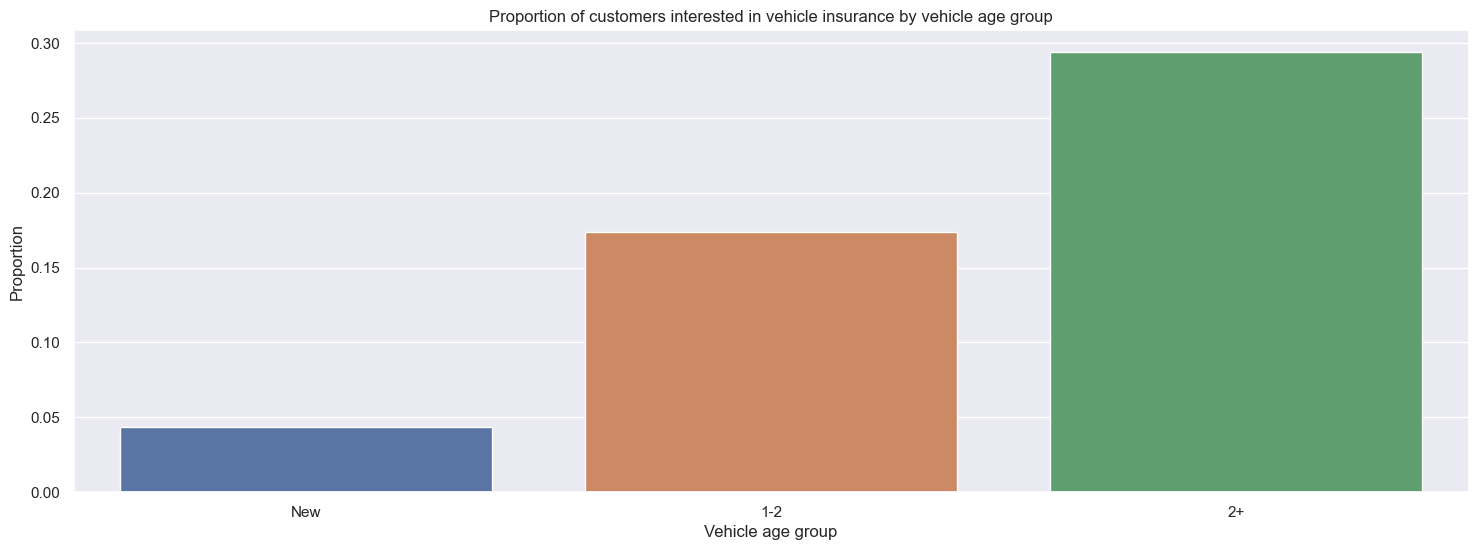

In [24]:
# Make a copy of the original dataframe
df_interest = df3.copy()

# Map the 'vehicle_age' column to numerical values
df_interest['vehicle_age'] = df_interest['vehicle_age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

# Create a new column with vehicle age groups
df_interest['vehicle_age_group'] = pd.cut(df_interest['vehicle_age'], bins=[-1, 0, 1, 2], labels=['New', '1-2', '2+'])

# Group by vehicle age group and calculate the proportion of customers interested in vehicle insurance
df_prop = df_interest.groupby('vehicle_age_group')['response'].mean().reset_index()

# Plot a bar chart of the proportion of customers interested in vehicle insurance by vehicle age group
plt.figure(figsize=(18, 6))
sns.barplot(x='vehicle_age_group', y='response', data=df_prop)
plt.title('Proportion of customers interested in vehicle insurance by vehicle age group')
plt.xlabel('Vehicle age group')
plt.ylabel('Proportion')
plt.show()


### 3.2.4. Customers who have experienced vehicle damage in the past are less likely to be interested in vehicle insurance as they may already have coverage.

    False premise. In fact, customers who have already had some type of damage to their vehicle have a greater tendency to be interested in a new car insurance, while more than 99% of those who have not had any damage still tend to have no interest in a new car insurance.

In [25]:

# Calculate the percentage of customers who have previously experienced vehicle damage
vehicle_damage_count = df3["vehicle_damage"].value_counts()
vehicle_damage_percent = vehicle_damage_count / df3.shape[0] * 100


# Calculate the percentage of customers who have previously experienced vehicle damage and are not interested in vehicle insurance
not_interested_damage_count = df3[(df3["vehicle_damage"] == "Yes") & (df3["response"] == 0)].shape[0]
not_interested_damage_percent = not_interested_damage_count / df3.shape[0] * 100

# Calculate the percentage of customers who don`t have previously experienced vehicle damage and are not interested in vehicle insurance
not_interested_not_damage_count = df3[(df3["vehicle_damage"] == "No") & (df3["response"] == 0)].shape[0]
not_interested_not_damage_percent = not_interested_not_damage_count / df3.shape[0] * 100

# Calculate the percentage of customers who have previously experienced vehicle damage and are interested in vehicle insurance
interested_damage_count = df3[(df3["vehicle_damage"] == "Yes") & (df3["response"] == 1)].shape[0]
interested_damage_percent = interested_damage_count / df3.shape[0] * 100

# Calculate the percentage of customers who don`t have previously experienced vehicle damage and are interested in vehicle insurance
interested_not_damage_count = df3[(df3["vehicle_damage"] == "No") & (df3["response"] == 1)].shape[0]
interested_not_damage_percent = interested_not_damage_count / df3.shape[0] * 100

interested_table = [["No", "Yes", not_interested_damage_count, not_interested_damage_percent], ["No", "No", not_interested_not_damage_count, not_interested_not_damage_percent],
                    ["Yes", "Yes", interested_damage_count, interested_damage_percent], ["Yes", "No", interested_not_damage_percent, interested_not_damage_percent]]

df_interested_damage = pd.DataFrame(interested_table, columns=["Interested", "Damage", "Count", "Percentage"])
df_interested_damage


,Interested,Damage,Count,Percentage
0,No,Yes,146685.00,38.49
1,No,No,187714.00,49.25
2,Yes,Yes,45728.00,12.00
3,Yes,No,0.26,0.26


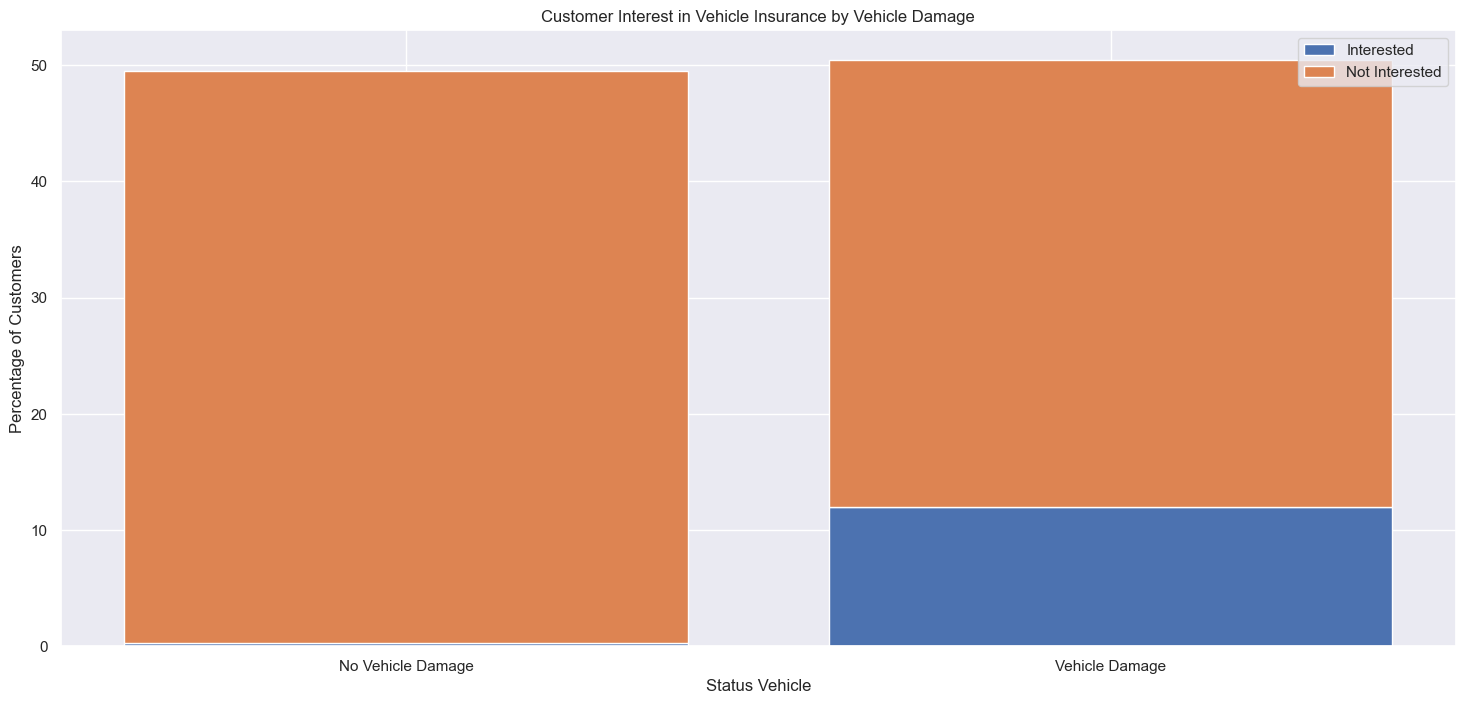

In [26]:

# Create a stacked bar chart
fig, ax = plt.subplots() 
ax.bar(["No Vehicle Damage", "Vehicle Damage"], [interested_not_damage_percent, interested_damage_percent], label="Interested")
ax.bar(["No Vehicle Damage", "Vehicle Damage"], [not_interested_not_damage_percent, not_interested_damage_percent], bottom=[interested_not_damage_percent, interested_damage_percent], label="Not Interested")
ax.set_xlabel("Status Vehicle")
ax.set_ylabel("Percentage of Customers")
ax.set_title("Customer Interest in Vehicle Insurance by Vehicle Damage")
ax.legend()
plt.show()

### 3.2.5. Customers who have a long association with the insurance company are more likely to be interested in vehicle insurance as they may have a stronger trust relationship with the company.

    Based on the customer's relationship period with the company, no significant variations were found that would prove the customers' interest in an automobile plan over time.

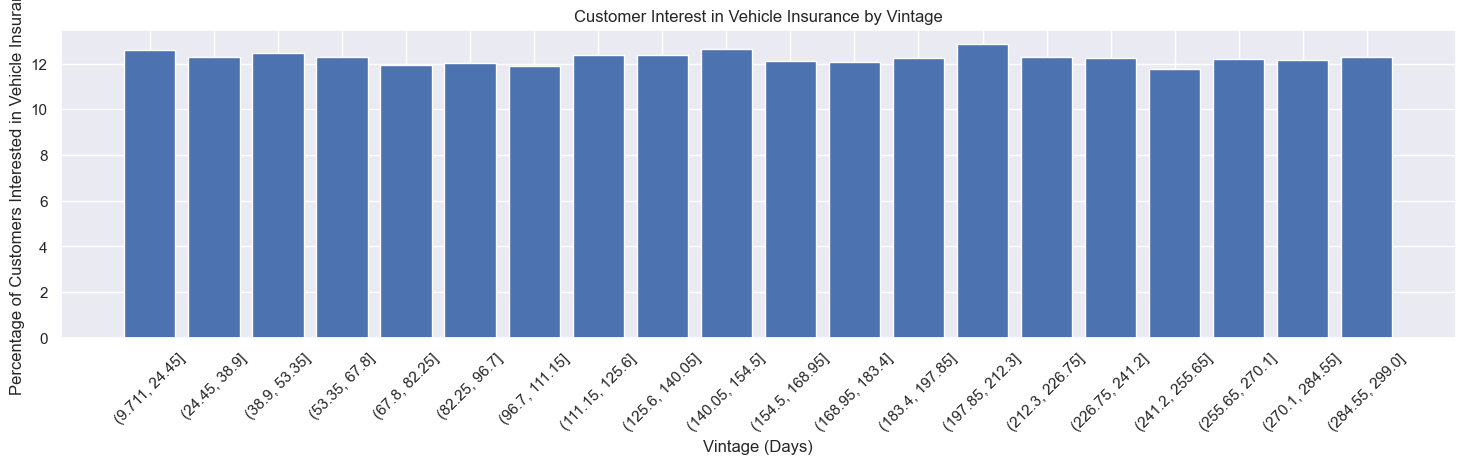

In [27]:
# Group customers by vintage and calculate the percentage of customers who are interested in vehicle insurance for each group
vintage_groups = df3.groupby(pd.cut(df3["vintage"], bins=20))
interest_percentages = vintage_groups["response"].mean() * 100

# Create a bar chart to visualize the relationship between vintage and customer interest in vehicle insurance
fig, ax = plt.subplots(figsize=(18,4))
plt.xticks(rotation=45)
ax.bar(interest_percentages.index.astype(str), interest_percentages.values)
ax.set_xlabel("Vintage (Days)")
ax.set_ylabel("Percentage of Customers Interested in Vehicle Insurance")
ax.set_title("Customer Interest in Vehicle Insurance by Vintage")
plt.show()


### 3.2.6. Male customers are more likely to be interested in vehicle insurance as they may be more likely to own and drive vehicles.
    Of the cases that have an interest in car insurance, men have about 25% more interest than women.

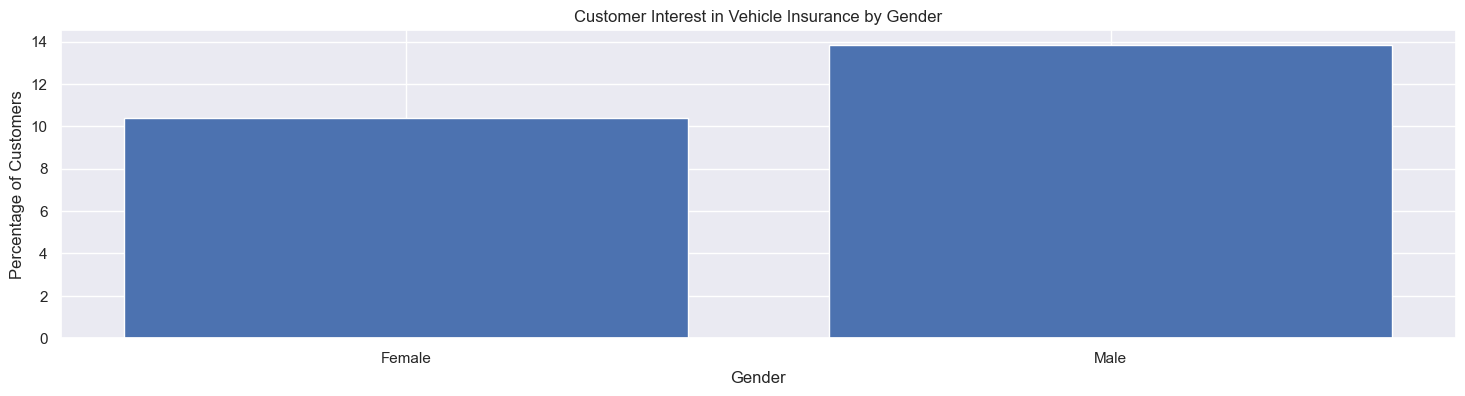

In [28]:
# Calculate the percentage of male and female customers who are interested in vehicle insurance
gender_count = df3["gender"].value_counts()
interested_by_gender = df3[df3["response"] == 1]["gender"].value_counts()
interested_percent = interested_by_gender / gender_count * 100

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(18,4))
ax.bar(["Female", "Male"], [interested_percent["Female"], interested_percent["Male"]])
ax.set_xlabel("Gender")
ax.set_ylabel("Percentage of Customers")
ax.set_title("Customer Interest in Vehicle Insurance by Gender")
plt.show()


### 3.2.7. Customers who have a higher annual premium for their current policy are less likely to be interested in vehicle insurance.
    Customers with an annual premium of over approximately 50 thousand and who already have insurance tend to have no interest in a new vehicle insurance.

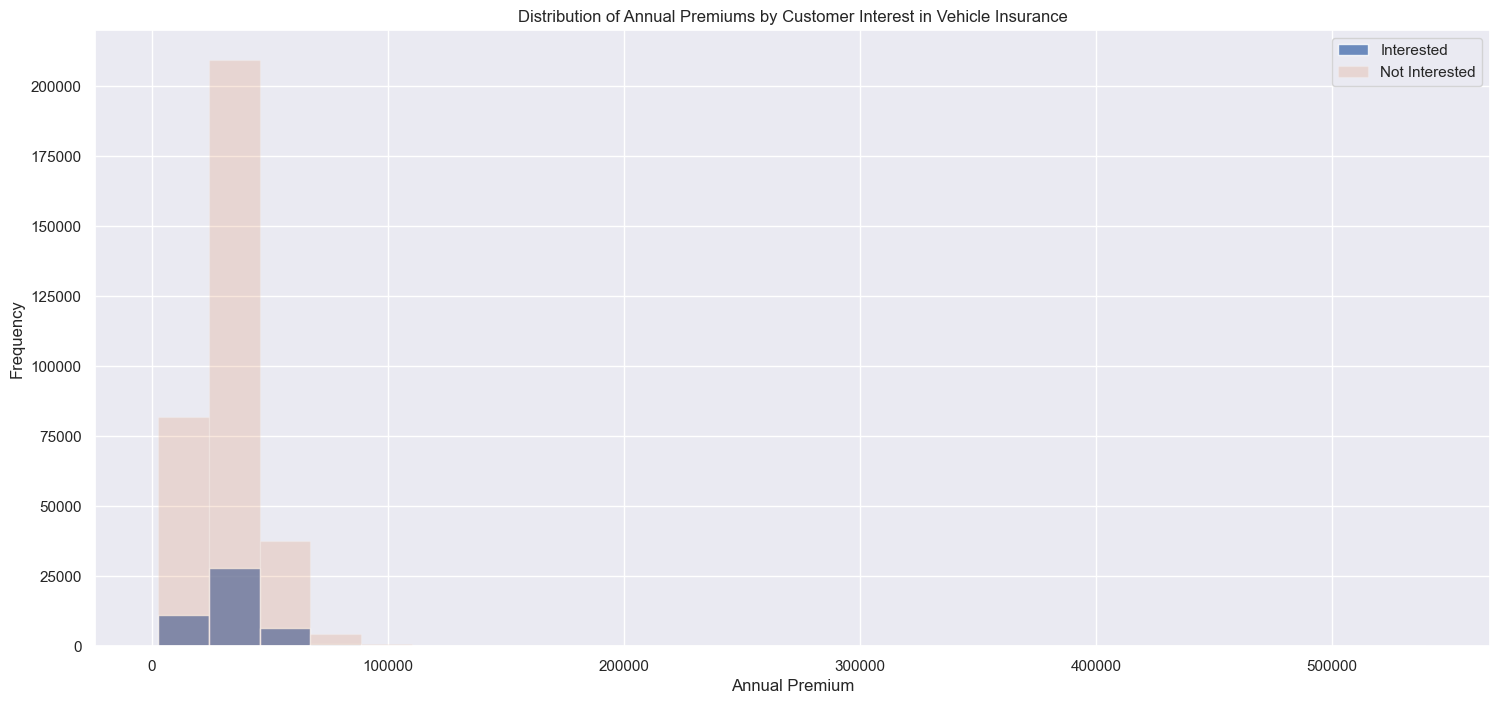

In [29]:
import matplotlib.pyplot as plt

# Separate customers into interested and not interested groups
interested_customers = df3[df3["response"] == 1]
not_interested_customers = df3[df3["response"] == 0]

# Create histograms of annual premiums for each group
fig, ax = plt.subplots()
ax.hist(interested_customers["annual_premium"], bins=25, alpha=0.8, label="Interested")
ax.hist(not_interested_customers["annual_premium"], bins=25, alpha=0.2, label="Not Interested")
ax.set_xlabel("Annual Premium")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Annual Premiums by Customer Interest in Vehicle Insurance")
ax.legend()
plt.show()


### 3.2.8. Customers who were contacted through certain policy sales channels, such as over the phone or in person, may be more likely to be interested in vehicle insurance compared to those contacted through other channels, such as over mail or email.

    The interest of customers compared by channels has an average percentage of less than 30%. In relation to the number of customers contacted and the percentage of channels, channels 3, 155, and 163 are the ones with the highest chances of acceptance.

Channel with more customers Interested: 163, Qtd: 880, Percentage: 30.418250950570343
Channel with more customers Interested: 155, Qtd: 395, Percentage: 32.0097244732577
Channel with more customers Interested: 3, Qtd: 159, Percentage: 30.401529636711285
Channel with more customers Interested: 36, Qtd: 17, Percentage: 32.69230769230769
Channel with more customers Interested: 28, Qtd: 1, Percentage: 33.33333333333333
Channel with more customers Interested: 27, Qtd: 1, Percentage: 33.33333333333333
Channel with more customers Interested: 123, Qtd: 1, Percentage: 100.0
Channel with more customers Interested: 43, Qtd: 1, Percentage: 100.0


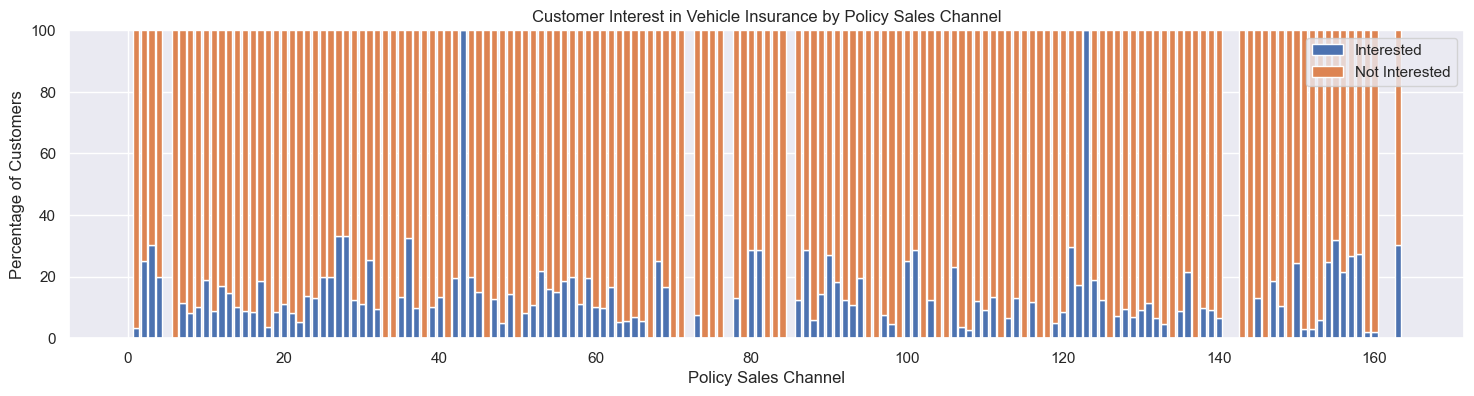

In [30]:
# Calculate the percentage of customers who are interested in vehicle insurance
interested_count = df3["response"].value_counts()
interested_percent = interested_count / df3.shape[0] * 100

# Calculate the percentage of customers who are interested in vehicle insurance, based on policy sales channel
channel_interested_percent = []
channel_names = []
for channel in df3["policy_sales_channel"].unique():
    channel_count = df3[(df3["policy_sales_channel"] == channel) & (df3["response"] == 1)].shape[0]
    channel_percent = channel_count / df3[df3["policy_sales_channel"] == channel].shape[0] * 100
    if channel_percent >= 30:
        print(f"Channel with more customers Interested: {channel}, Qtd: {channel_count}, Percentage: {channel_percent}")
    channel_interested_percent.append(channel_percent)
    channel_names.append(channel)

# Calculate the percentage of customers who are not interested in vehicle insurance, based on policy sales channel
channel_not_interested_percent = []
for i, channel in enumerate(channel_names):
    channel_count = df3[(df3["policy_sales_channel"] == channel) & (df3["response"] == 0)].shape[0]
    channel_percent = channel_count / df3[df3["policy_sales_channel"] == channel].shape[0] * 100
    channel_not_interested_percent.append(channel_percent)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(18, 4))
ax.bar(channel_names, channel_interested_percent, label="Interested")
ax.bar(channel_names, channel_not_interested_percent, bottom=channel_interested_percent, label="Not Interested")
ax.set_xlabel("Policy Sales Channel")
ax.set_ylabel("Percentage of Customers")
ax.set_title("Customer Interest in Vehicle Insurance by Policy Sales Channel")
ax.legend()
plt.show()


In [31]:
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,Yes,28,No,> 2 Years,Yes,40454.00,26,217,1
1,2,Male,76,Yes,3,No,1-2 Year,No,33536.00,26,183,0
2,3,Male,47,Yes,28,No,> 2 Years,Yes,38294.00,26,27,1
3,4,Male,21,Yes,11,Yes,< 1 Year,No,28619.00,152,203,0
4,5,Female,29,Yes,41,Yes,< 1 Year,No,27496.00,152,39,0


### 3.2.9. Regions with the highest percentage of customers tend to have the widest acceptance area for insurance.

    As verified in the graph below, areas with the highest percentage of customers are indeed the ones that have a higher acceptance from them to acquire a new insurance.

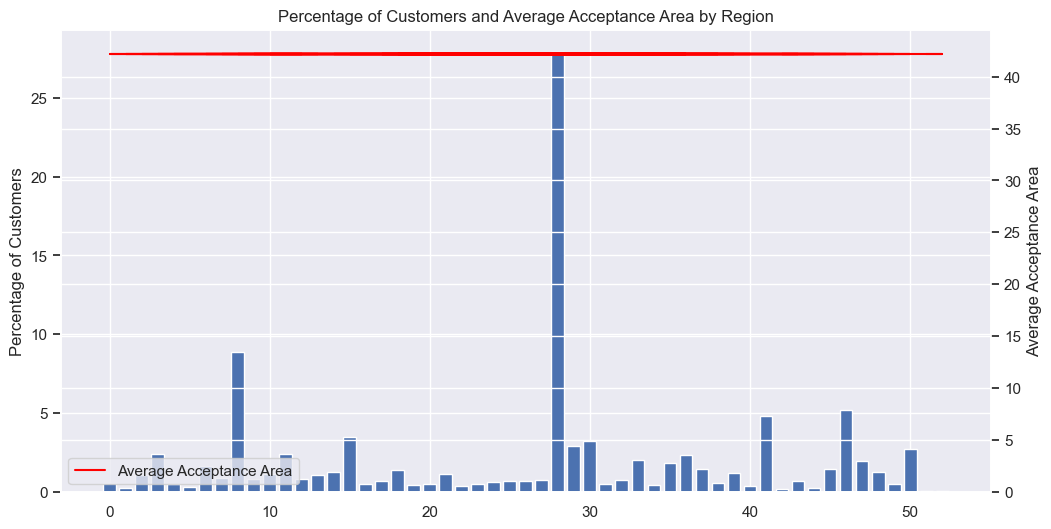

In [32]:
region_count = df3['region_code'].value_counts()
region_percent = region_count / df3.shape[0] * 100

region_avg_acceptance = df3.groupby('region_code')['policy_sales_channel'].nunique().mean()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(region_percent.index, region_percent.values, label='Percentage of Customers')
ax.set_ylabel('Percentage of Customers')

ax2 = ax.twinx()
ax2.plot(region_percent.index, [region_avg_acceptance] * len(region_percent), color='red', label='Average Acceptance Area')
ax2.set_ylabel('Average Acceptance Area')
ax2.set_ylim(bottom=0)

plt.title('Percentage of Customers and Average Acceptance Area by Region')
plt.legend()
plt.show()


### 3.2.10. Customers who do not have a driver's license tend not to adhere to vehicle insurance.
    True premisse

response              0      1
driving_license               
No                  771     41
Yes              333628  46669


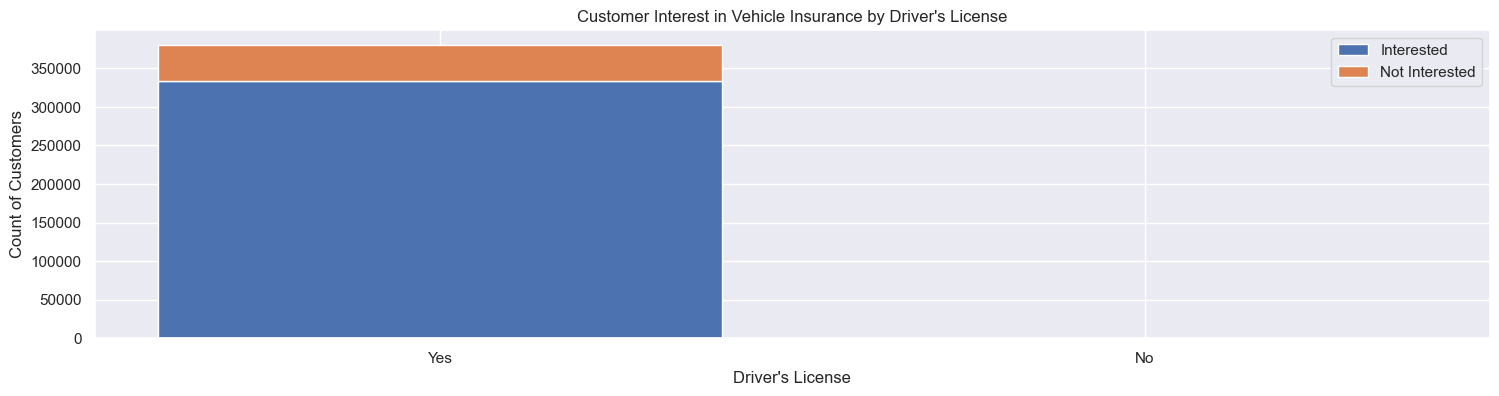

In [33]:
# Count the number of customers with and without a driver's license and their interest in vehicle insurance
dl_counts = df3["driving_license"].value_counts()
dl_interest = df3.groupby("driving_license")["response"].value_counts().unstack().fillna(0)

# Calculate the percentage of customers who are interested in vehicle insurance
interested_count = df3["response"].value_counts()
interested_percent = interested_count / df3.shape[0] * 100
print(dl_interest)
# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(18, 4))
ax.bar(dl_counts.index.astype(str), [ dl_interest[0][1], dl_interest[0][0] ], label="Interested")
ax.bar(dl_counts.index.astype(str), [ dl_interest[1][1], dl_interest[1][0] ], bottom=[ dl_interest[0][1], dl_interest[0][0] ], label="Not Interested")
ax.set_xlabel("Driver's License")
ax.set_ylabel("Count of Customers")
ax.set_title("Customer Interest in Vehicle Insurance by Driver's License")
ax.legend()
plt.show()


### 3.2.11. There is a greater risk of accidents occurring in customers who are younger.
    Premisse is true.

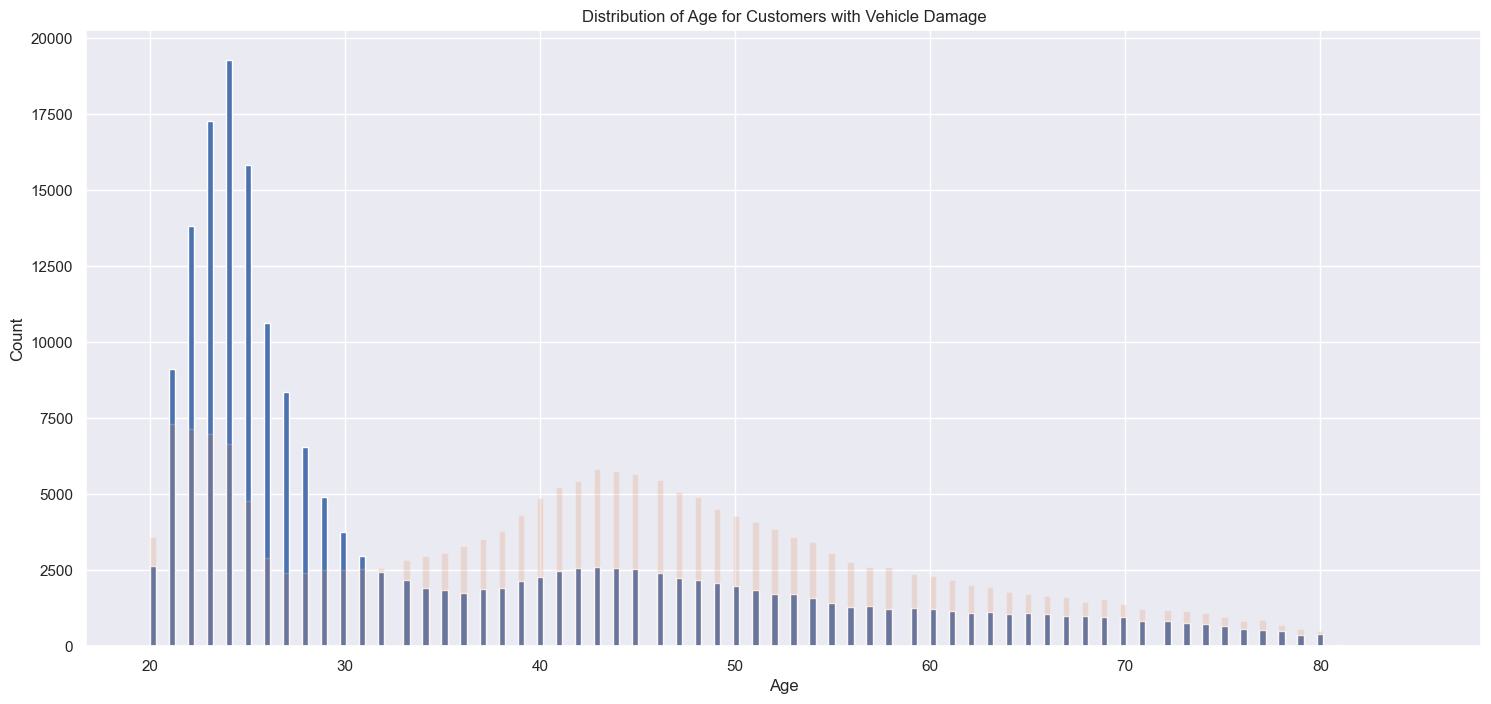

In [34]:
# Filter the data to include only customers with vehicle damage
vehicle_damage_data_yes = df3[df3["vehicle_damage"] == "Yes"]
vehicle_damage_data_no = df3[df3["vehicle_damage"] == "No"]

# Create a histogram of the ages
plt.hist(vehicle_damage_data_no["age"], bins=200, alpha=1, label="No Vehicle Damage")
plt.hist(vehicle_damage_data_yes["age"], bins=200, alpha=0.2, label="Vehicle Damage")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age for Customers with Vehicle Damage")
plt.show()

### 3.2.12. Customers who own vehicles less than a year old cause more accidents.

    In fact, older vehicles have a higher accident rate compared to newer ones.

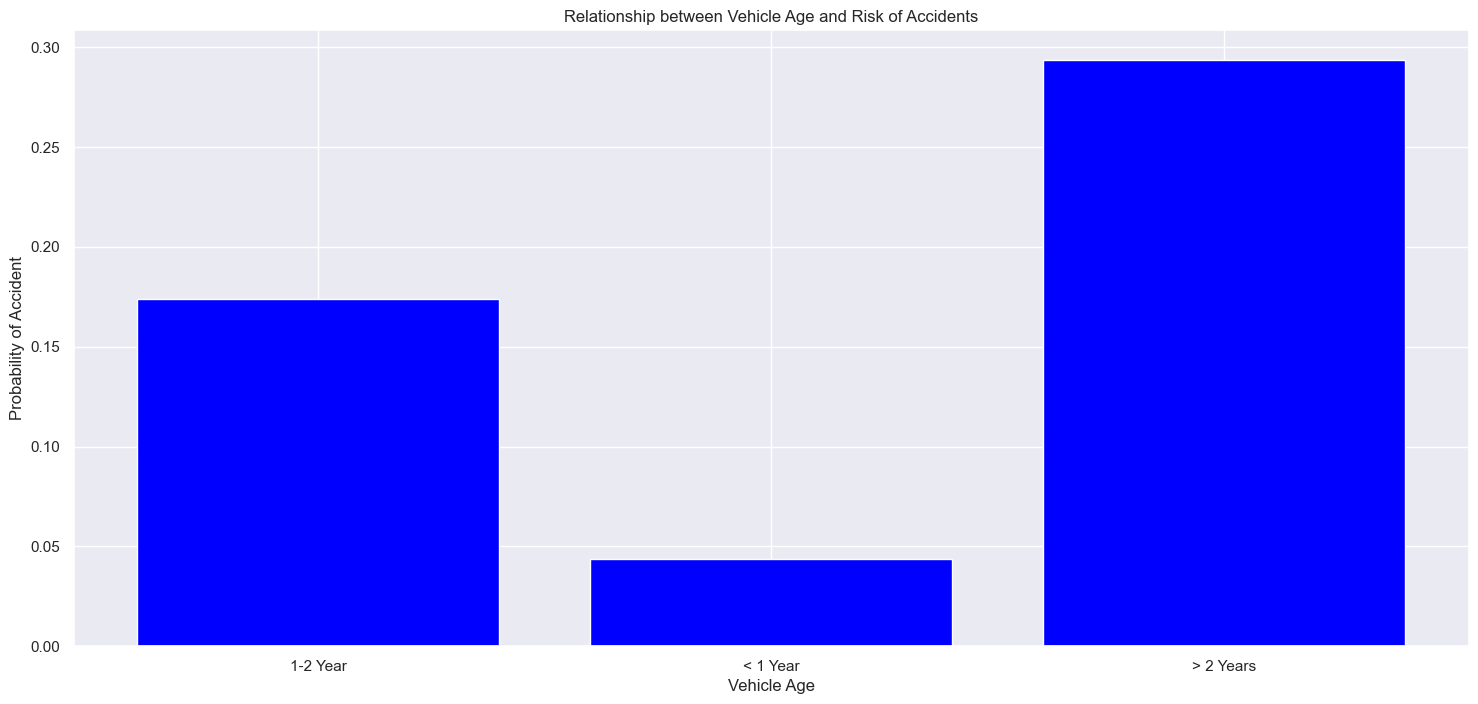

In [35]:
# Create a new dataframe with the age of the vehicles and the probability of accidents
vehicle_age_data = df3.groupby('vehicle_age')['response'].mean().reset_index()

# Create a bar chart
plt.bar(vehicle_age_data['vehicle_age'], vehicle_age_data['response'], color='blue')

# Set the plot labels and title
plt.xlabel('Vehicle Age')
plt.ylabel('Probability of Accident')
plt.title('Relationship between Vehicle Age and Risk of Accidents')

# Show the plot
plt.show()


## 3.3. Multivariate Analysis

### 3.3.1. Numerical Attributes

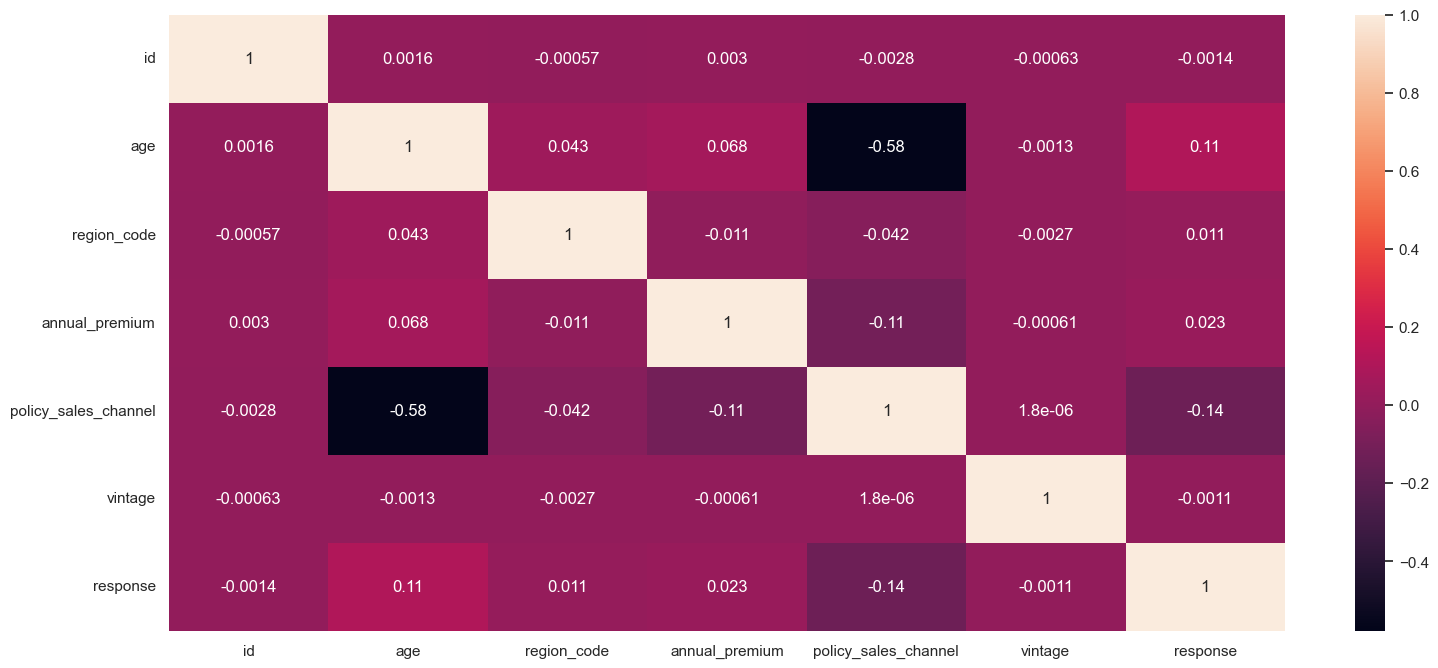

In [36]:
num_correlation = num_attributes.corr(method='pearson')
sns.heatmap(num_correlation, annot=True);

### 3.3.2. Categorical Attributes

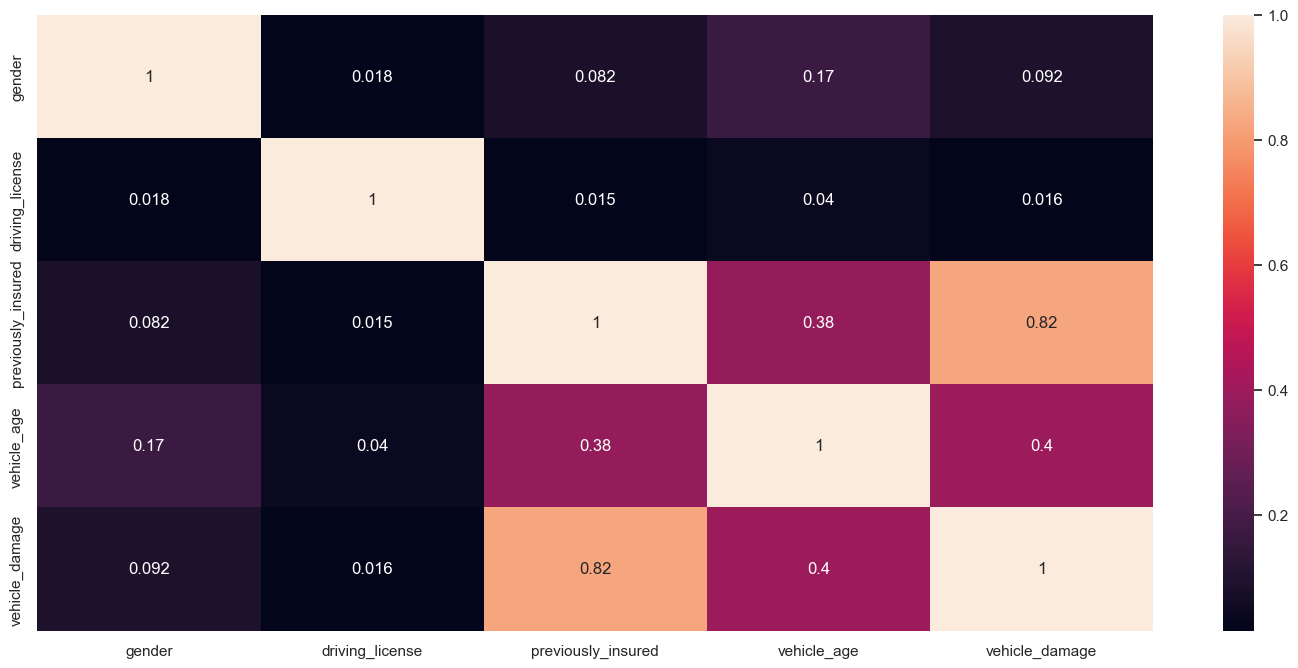

In [37]:
cat_attr2 = cat_attributes[['gender', 'driving_license', 'previously_insured', 'vehicle_age',
       'vehicle_damage']]

a1 = cramer_v_bias_correction(cat_attr2['gender'], cat_attr2['gender'])
a2 = cramer_v_bias_correction(cat_attr2['gender'], cat_attr2['driving_license'])
a3 = cramer_v_bias_correction(cat_attr2['gender'], cat_attr2['previously_insured'])
a4 = cramer_v_bias_correction(cat_attr2['gender'], cat_attr2['vehicle_age'])
a5 = cramer_v_bias_correction(cat_attr2['gender'], cat_attr2['vehicle_damage'])

b1 = cramer_v_bias_correction(cat_attr2['driving_license'], cat_attr2['gender'])
b2 = cramer_v_bias_correction(cat_attr2['driving_license'], cat_attr2['driving_license'])
b3 = cramer_v_bias_correction(cat_attr2['driving_license'], cat_attr2['previously_insured'])
b4 = cramer_v_bias_correction(cat_attr2['driving_license'], cat_attr2['vehicle_age'])
b5 = cramer_v_bias_correction(cat_attr2['driving_license'], cat_attr2['vehicle_damage'])

c1 = cramer_v_bias_correction(cat_attr2['previously_insured'], cat_attr2['gender'])
c2 = cramer_v_bias_correction(cat_attr2['previously_insured'], cat_attr2['driving_license'])
c3 = cramer_v_bias_correction(cat_attr2['previously_insured'], cat_attr2['previously_insured'])
c4 = cramer_v_bias_correction(cat_attr2['previously_insured'], cat_attr2['vehicle_age'])
c5 = cramer_v_bias_correction(cat_attr2['previously_insured'], cat_attr2['vehicle_damage'])

d1 = cramer_v_bias_correction(cat_attr2['vehicle_age'], cat_attr2['gender'])
d2 = cramer_v_bias_correction(cat_attr2['vehicle_age'], cat_attr2['driving_license'])
d3 = cramer_v_bias_correction(cat_attr2['vehicle_age'], cat_attr2['previously_insured'])
d4 = cramer_v_bias_correction(cat_attr2['vehicle_age'], cat_attr2['vehicle_age'])
d5 = cramer_v_bias_correction(cat_attr2['vehicle_age'], cat_attr2['vehicle_damage'])

e1 = cramer_v_bias_correction(cat_attr2['vehicle_damage'], cat_attr2['gender'])
e2 = cramer_v_bias_correction(cat_attr2['vehicle_damage'], cat_attr2['driving_license'])
e3 = cramer_v_bias_correction(cat_attr2['vehicle_damage'], cat_attr2['previously_insured'])
e4 = cramer_v_bias_correction(cat_attr2['vehicle_damage'], cat_attr2['vehicle_age'])
e5 = cramer_v_bias_correction(cat_attr2['vehicle_damage'], cat_attr2['vehicle_damage'])

df_crammer = pd.DataFrame( {'gender': [a1, a2, a3, a4, a5],
               'driving_license':    [b1, b2, b3, b4, b5],
               'previously_insured':    [c1, c2, c3, c4, c5],
               'vehicle_age': [d1, d2, d3, d4, d5],
               'vehicle_damage':    [e1, e2, e3, e4, e5]})

df_crammer = df_crammer.set_index(df_crammer.columns)

sns.heatmap(df_crammer, annot=True);

# 4.0. Feature Engineering

In [38]:
df4 = df3.copy()

In [39]:
#creating new periods conforming months
df4["around_one_month"] = df4["vintage"].apply( lambda x: 1 if x <= 30 else 0)
df4["one_three_month"]  = df4["vintage"].apply( lambda x: 1 if x > 30 and x < 90 else 0)
df4["three_six_month"]  = df4["vintage"].apply( lambda x: 1 if x > 90 and x < 180 else 0)
df4["six_twelve_month"] = df4["vintage"].apply( lambda x: 1 if x > 180 and x < 365 else 0)
df4["more_one_year"]    = df4["vintage"].apply( lambda x: 1 if x > 365 else 0)

#risk column
group1 = df4[df4["vehicle_age"] == "< 1 Year"]["age"].value_counts()
group2 = df4[df4["vehicle_age"] == "1-2 Year"]["age"].value_counts()
group3 = df4[df4["vehicle_age"] == "> 2 Years"]["age"].value_counts()

# Defining the conditions for each risk level
low = (
    (df4["vehicle_damage"] == "No")
)

moderate = (
    (df4["vehicle_damage"] == "Yes") & 
    
    ((df4["vehicle_age"] == "< 1 Year") & 
     (df4["age"] >= 30)) |
    
    ((df4["vehicle_age"] == "1-2 Year") & 
     ((df4["age"] <= 30) | (df4["age"] > 70) ))
)

high = (    
    (df4["vehicle_age"] == "> 2 Years") |
    
    ((df4["vehicle_damage"] == "Yes") &
    ((df4["vehicle_age"] == "< 1 Year") &
    (df4["age"] < 30)) |
    
    ((df4["vehicle_age"] == "1-2 Year") & 
     ((df4["age"] > 30) | (df4["age"] <= 70) )))
)

# Creating the "risk" column based on the defined conditions
df4["risk"] = ""
df4.loc[low, "risk"] = "low"
df4.loc[moderate, "risk"] = "moderate"
df4.loc[high, "risk"] = "high"

df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,around_one_month,one_three_month,three_six_month,six_twelve_month,more_one_year,risk
0,1,Male,44,Yes,28,No,> 2 Years,Yes,40454.00,26,217,1,0,0,0,1,0,high
1,2,Male,76,Yes,3,No,1-2 Year,No,33536.00,26,183,0,0,0,0,1,0,high
2,3,Male,47,Yes,28,No,> 2 Years,Yes,38294.00,26,27,1,1,0,0,0,0,high
3,4,Male,21,Yes,11,Yes,< 1 Year,No,28619.00,152,203,0,0,0,0,1,0,low
4,5,Female,29,Yes,41,Yes,< 1 Year,No,27496.00,152,39,0,0,1,0,0,0,low


# 5.0. Data Preparation

    Step to predict which customers are most likely to say yes to the insurance plan and are least at risk of filing a claim, we can use machine learning algorithms. Let's split the df5 dataset into training and validation data and then apply different algorithms to build the model and evaluate its performance.    

In [40]:
df5 = df4.drop(columns='id', axis=1).copy()

## 5.1. Split dataframe into training (x) and validation (y) dataset

In [41]:
X = df5.drop(columns="response", axis=1).copy()
y = df5['response'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=28)


## 5.2. Rescaling

In [42]:
scaler = RobustScaler()

# Define the columns to scale
cols_to_scale = ['annual_premium', 'age']

# Apply RobustScaler to the columns
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_val[cols_to_scale]   = scaler.fit_transform(X_val[cols_to_scale])

## 5.3. Encoding

In [43]:
# Define the columns to encode
ordinal_enc = OrdinalEncoder()
cols_to_encode = ['vehicle_age', 'risk', 'driving_license', 'previously_insured', 'vehicle_damage']
# Apply the encoding to the selected columns
X_train[cols_to_encode] = ordinal_enc.fit_transform(X_train[cols_to_encode])
X_val[cols_to_encode] = ordinal_enc.fit_transform(X_val[cols_to_encode])

# Encoding "gender" column as frequency
gender_freq = X_train['gender'].value_counts(normalize=True)
X_train['gender'] = X_train['gender'].map(gender_freq)

gender_freq_v = X_val['gender'].value_counts(normalize=True)
X_val['gender'] = X_val['gender'].map(gender_freq_v)

# Encoding "region_code" column as frequency
region_freq = X_train['region_code'].value_counts(normalize=True)
X_train['region_code'] = X_train['region_code'].map(region_freq)

region_freq_v = X_val['region_code'].value_counts(normalize=True)
X_val['region_code'] = X_val['region_code'].map(region_freq_v)

# Encoding "policy_sales_channel" column as frequency
policy_freq = X_train['policy_sales_channel'].value_counts(normalize=True)
X_train['policy_sales_channel'] = X_train['policy_sales_channel'].map(policy_freq)

policy_freq_v = X_val['policy_sales_channel'].value_counts(normalize=True)
X_val['policy_sales_channel'] = X_val['policy_sales_channel'].map(policy_freq_v)

# Encoding "vintage" column as frequency
vintage_freq = X_train['vintage'].value_counts(normalize=True)
X_train['vintage'] = X_train['vintage'].map(vintage_freq)

vintage_freq_v = X_val['vintage'].value_counts(normalize=True)
X_val['vintage'] = X_val['vintage'].map(vintage_freq_v)

# 6.0. Feature Selection
    Note: Using Boruta algorithm

## 6.1. Random Forest feature importance

    This code trains a Random Forest Classifier on the training data and then retrieves the feature importances for each feature. The features are then sorted by importance and the top 10 features are printed out. This strategy can help identify the most important features for the model and can be used to remove less important features, potentially improving the model's performance and reducing processing time.

In [44]:

# Train a Random Forest Classifier on the training data
rfc = RandomForestClassifier(random_state=28)
rfc.fit(X_train, y_train)

# Get feature importances
importances = rfc.feature_importances_

# Create a list of feature names and their importances
feature_importances = [(feature, importance) for feature, importance in zip(X_train.columns, importances)]

# Sort the features by importance (in descending order)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the top 10 features by importance
for feature, importance in feature_importances[:10]:
    print(f"{feature}: {importance:.4f}")
    

annual_premium: 0.2472
vintage: 0.2211
age: 0.1646
region_code: 0.1098
policy_sales_channel: 0.0744
vehicle_damage: 0.0595
previously_insured: 0.0583
risk: 0.0142
gender: 0.0140
vehicle_age: 0.0105


## 6.2. Random Forest feature importance with RFE
    This code fits an RFE object with a Random Forest classifier and selects the top 10 features.

In [45]:
# Define the model to use
model = RandomForestClassifier()

# Define the number of features to select
n_features = 10

# Define the RFE object
rfe = RFE(estimator=model, n_features_to_select=n_features)

# Fit the RFE object to the data
rfe.fit(X_train, y_train)

# Print the selected features
print(X_train.columns[rfe.support_])

Index(['gender', 'age', 'region_code', 'previously_insured', 'vehicle_damage',
       'annual_premium', 'policy_sales_channel', 'vintage', 'six_twelve_month',
       'risk'],
      dtype='object')


## 6.3. Logistic Regression feature importance with RFE
    This code defines a logistic regression model and then uses RFE to recursively remove the least important features until only the top 10 features remain.

In [46]:
# Define the model to use
model = LogisticRegression(max_iter=1000)

# Define the RFE object and select the top 5 features
rfe = RFE(model, n_features_to_select=7)

# Fit the RFE object to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

# Print the selected features
print(selected_features)

Index(['gender', 'driving_license', 'region_code', 'previously_insured',
       'vehicle_damage', 'policy_sales_channel', 'risk'],
      dtype='object')


## 6.4. Columns Selected

annual_premium: 0.2472
vintage: 0.2211
age: 0.1646
region_code: 0.1098
policy_sales_channel: 0.0744
vehicle_damage: 0.0595
previously_insured: 0.0583
risk: 0.0142
gender: 0.0140
vehicle_age: 0.0105

In [99]:
features_selected = [ "annual_premium", "vintage", "age", "region_code", "policy_sales_channel",
                    "vehicle_damage", "previously_insured"]

# 7.0. Machine Learning Modeling

In [100]:
X_train = X_train[ features_selected ]
X_val  = X_val[ features_selected ]

## 7.1. Baseline Model

In [101]:
# Define the baseline model
dummy = DummyClassifier(strategy="most_frequent")

# Train the model
dummy.fit(X_train, y_train)

# Make predictions on the test set
y_hat_dummy_proba = dummy.predict_proba(X_val)



### 7.1.1. Performance

In [102]:
# Compute precision and recall
performance_dummy = compute_precision_recall_at_k(y_val, y_hat_dummy_proba[:, 1], k=20000)
print(f'Dummy Classifier - Precision@20000: {performance_dummy[0]:.3f} | Recall@20000: {performance_dummy[1]:.3f}')


Dummy Classifier - Precision@20000: 0.431 | Recall@20000: 0.916


### 7.1.2. Cross Validation

In [103]:
# Cross Validation
dummy_cross_val = cross_validation('Dummy', DummyClassifier(strategy="most_frequent"), X_train, y_train, k=20000, n_splits=5, random_state=28)
dummy_cross_val

,Precision@20000,Recall@20000
Dummy,0.36 +/- 0.0,0.97 +/- 0.0


### 7.1.3. Cumulative Gain Curve

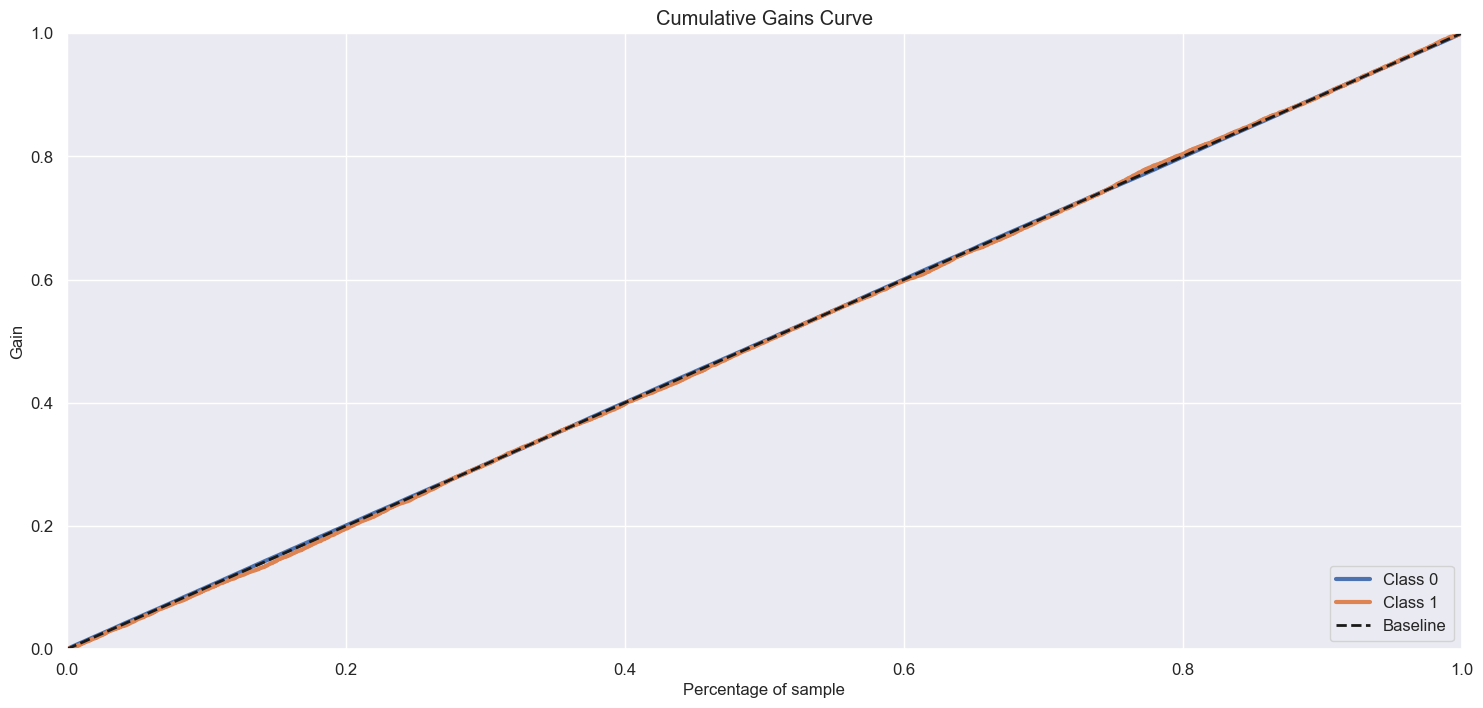

In [104]:
plot_cumulative_gain(y_val, y_hat_dummy_proba)
plt.show()

### 7.1.4. Lift Curve

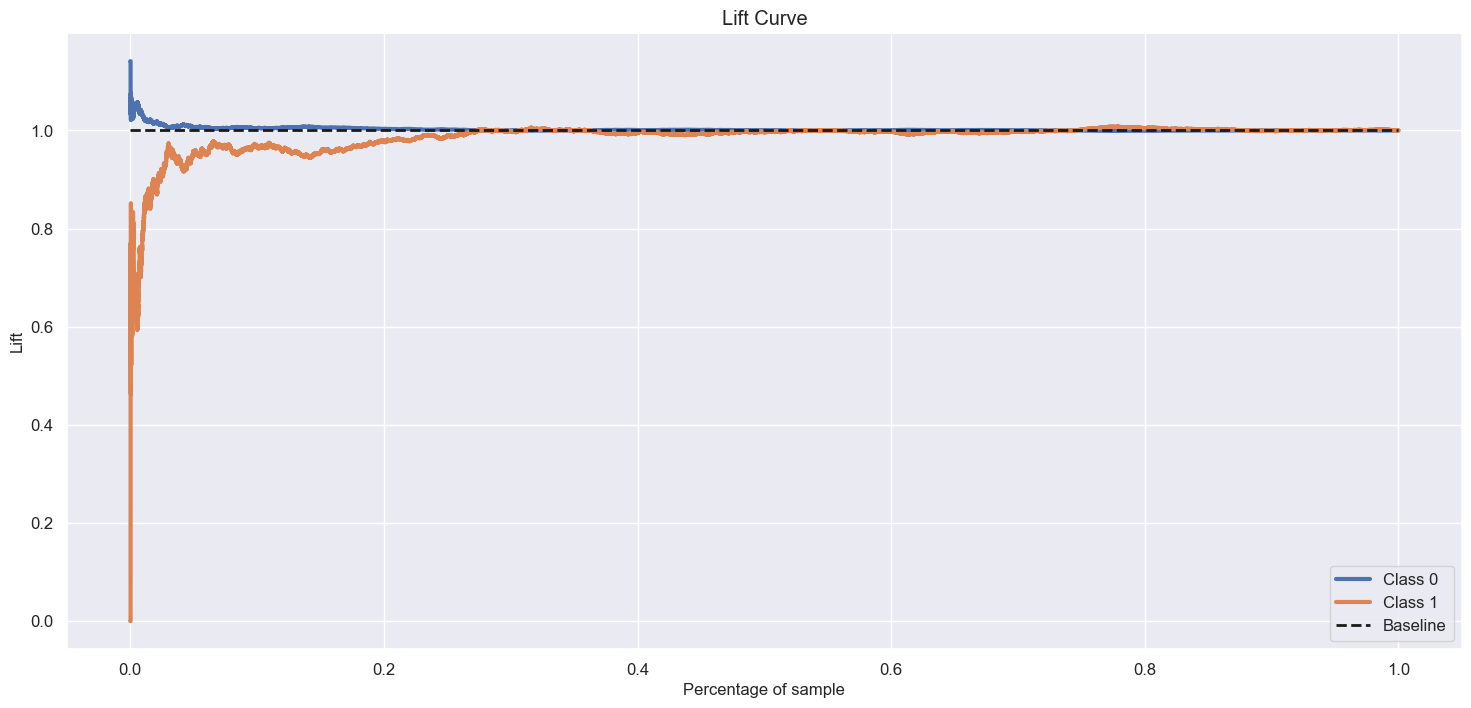

In [105]:
plot_lift_curve(y_val, y_hat_dummy_proba)
plt.show()

## 7.2. Logistic Regression

In [110]:
# Define the baseline model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_hat_log_reg_proba = log_reg.predict_proba(X_val)

### 7.2.1. Performance

In [55]:
# Compute precision and recall
performance_log_reg = compute_precision_recall_at_k(y_val, y_hat_log_reg_proba[:, 1], k=20000)
print(f'Logic Regression - Precision@20000: {performance_log_reg[0]:.3f} | Recall@20000: {performance_log_reg[1]:.3f}')


Logic Regression - Precision@20000: 0.471 | Recall@20000: 1.000


### 7.2.2. Cross Validation

In [111]:
# Cross Validation
log_reg_cross_val = cross_validation('Logistic Regression', LogisticRegression(), X_train, y_train, k=20000, n_splits=5, random_state=28)
log_reg_cross_val

,Precision@20000,Recall@20000
Logistic Regression,0.23 +/- 0.13,0.61 +/- 0.36


### 7.2.3. Cumulative Gain Curve

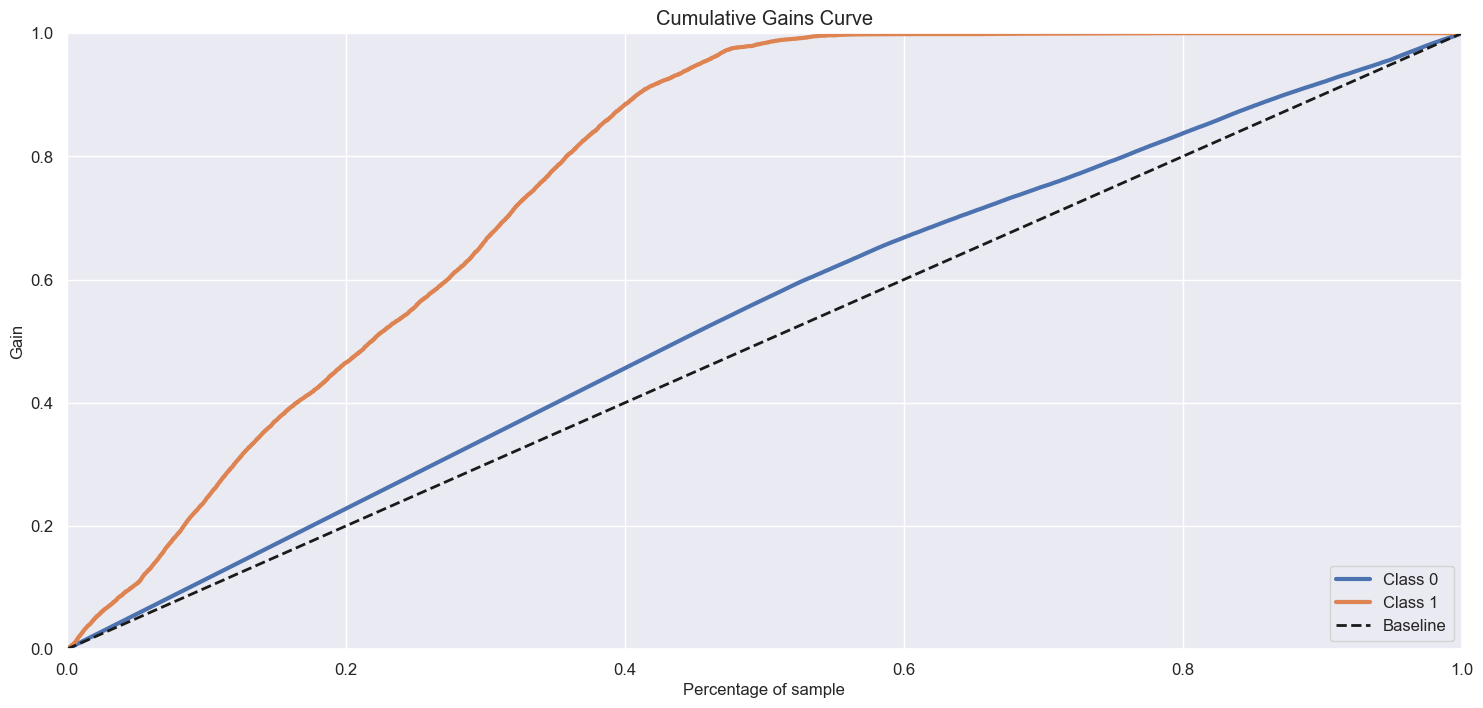

In [112]:
plot_cumulative_gain(y_val, y_hat_log_reg_proba)
plt.show()

### 7.2.4. Lift Curve

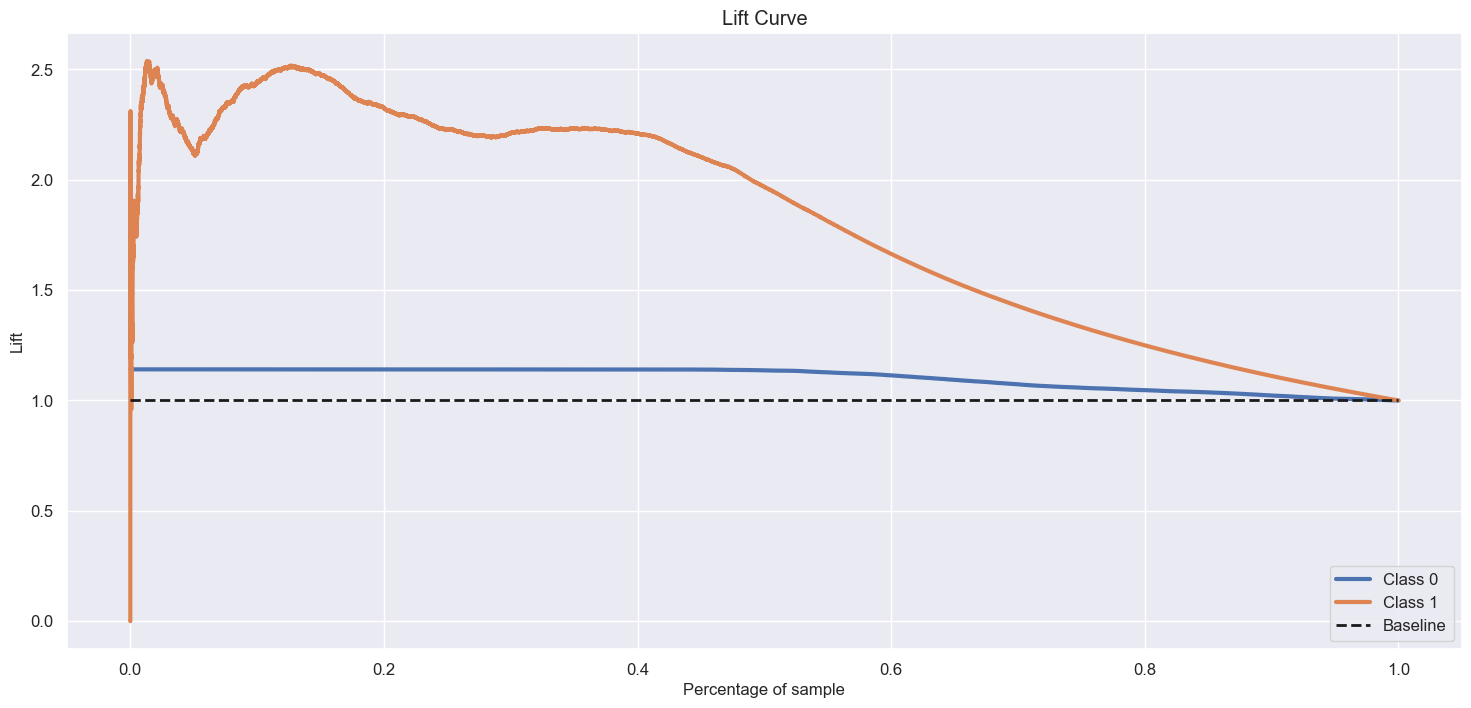

In [113]:
plot_lift_curve(y_val, y_hat_log_reg_proba);

## 7.3. Random Forest

In [128]:
# Define the baseline model
rf = RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_hat_rf_proba = rf.predict_proba(X_val)

### 7.3.1. Performance

In [60]:
# Compute precision and recall
performance_rf = compute_precision_recall_at_k(y_val, y_hat_rf_proba[:, 1], k=20000)
print(f'Random Florest - Precision@20000: {performance_rf[0]:.3f} | Recall@20000: {performance_rf[1]:.3f}')

Random Florest - Precision@20000: 0.469 | Recall@20000: 0.996


### 7.3.2. Cross Validation

In [129]:
# Cross Validation
rf_cross_val = cross_validation('Random Florest', RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1), X_train, y_train, k=20000, n_splits=5, random_state=28)
rf_cross_val

,Precision@20000,Recall@20000
Random Florest,0.33 +/- 0.04,0.9 +/- 0.12


### 7.3.3. Cumulative Gain Curve

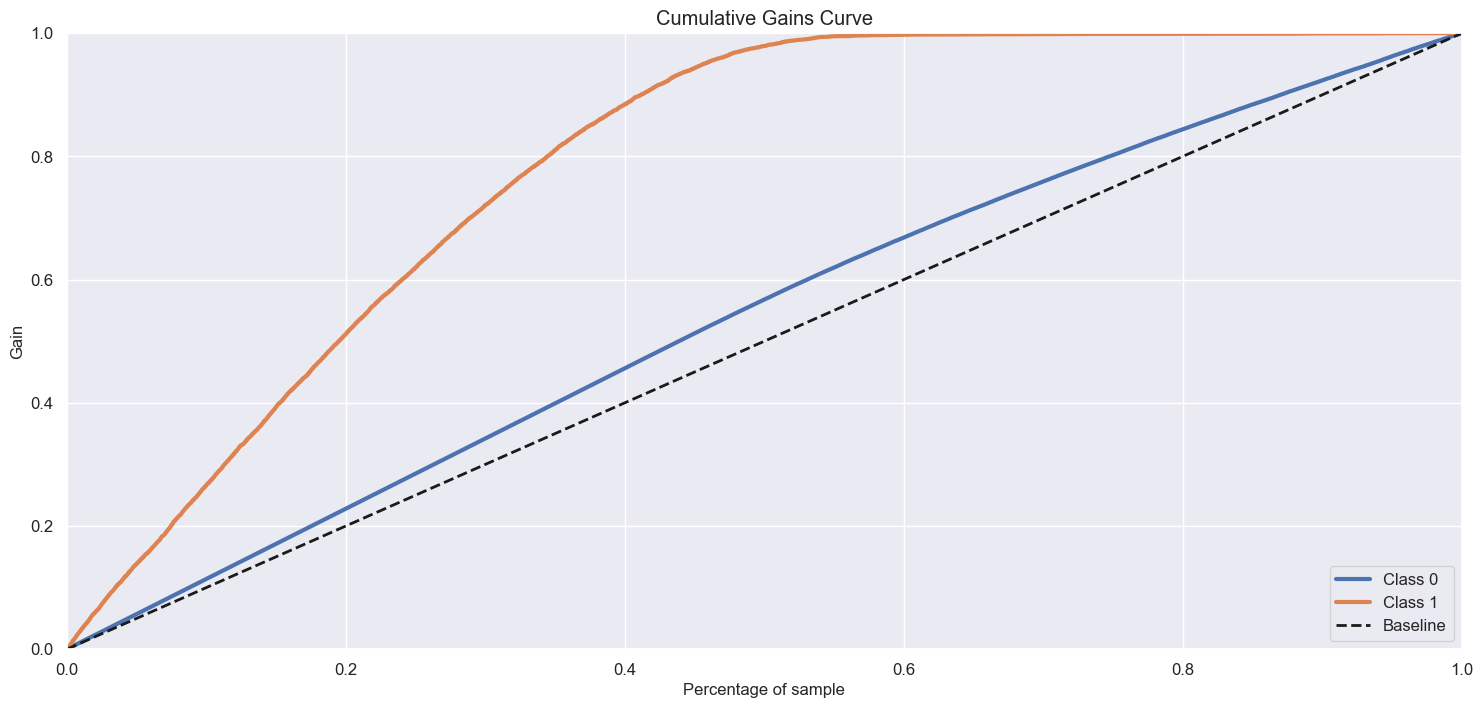

In [130]:
plot_cumulative_gain(y_val, y_hat_rf_proba);

### 7.3.4. Lift Curve

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

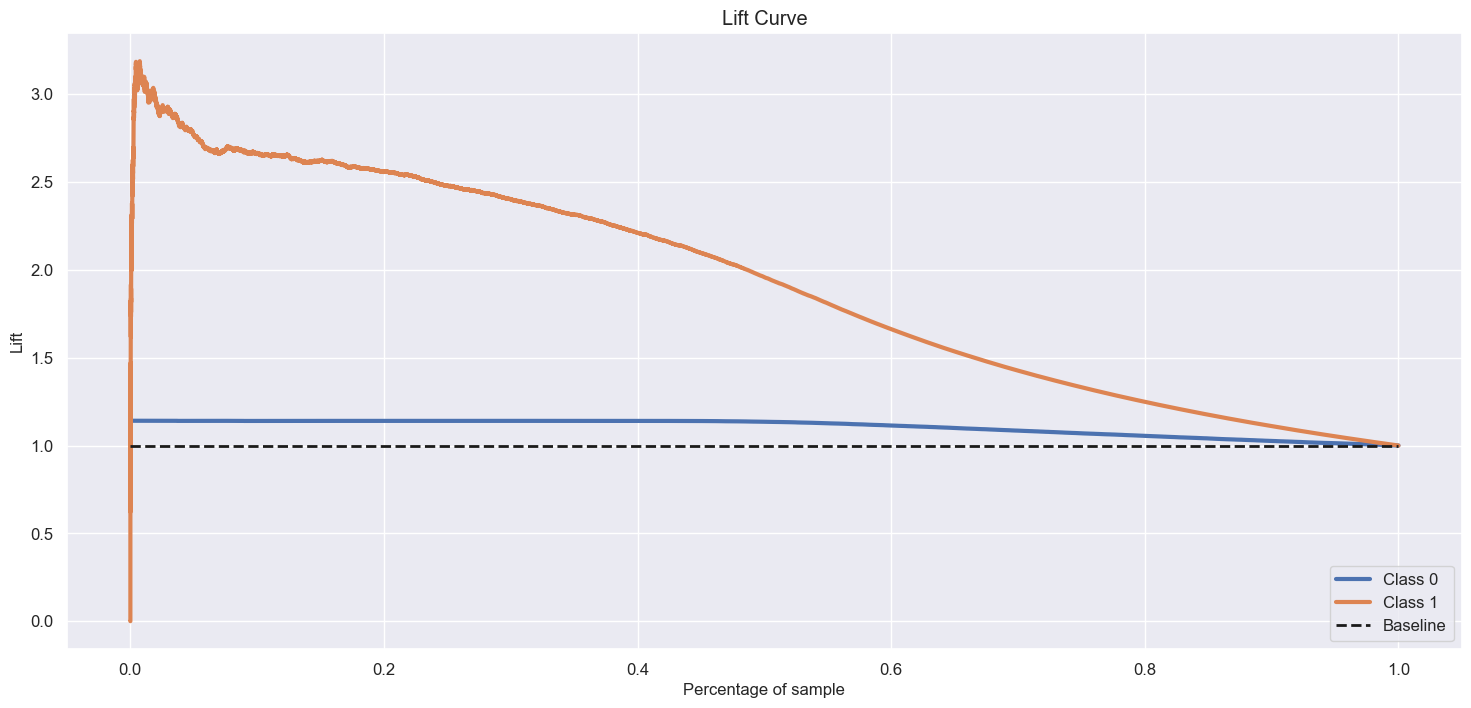

In [131]:
plot_lift_curve(y_val, y_hat_rf_proba)

## 7.4. Extra Trees

In [132]:
extra_trees = ExtraTreesClassifier(n_estimators=1000)

extra_trees.fit(X_train, y_train)

y_hat_et_proba = extra_trees.predict_proba(X_val)

### 7.4.1. Performance

In [133]:
# Compute precision and recall
performance_et = compute_precision_recall_at_k(y_val, y_hat_et_proba[:, 1], k=20000)
print(f'Extra Trees - Precision@20000: {performance_et[0]:.3f} | Recall@20000: {performance_et[1]:.3f}')

Extra Trees - Precision@20000: 0.470 | Recall@20000: 0.998


### 7.4.2. Cross Validation

In [134]:
# Cross Validation
et_cross_val = cross_validation('Extra Trees', ExtraTreesClassifier(n_estimators=1000), X_train, y_train, k=20000, n_splits=5, random_state=28)
et_cross_val

,Precision@20000,Recall@20000
Extra Trees,0.32 +/- 0.06,0.85 +/- 0.17


### 7.4.3. Cumulative Gain Curve

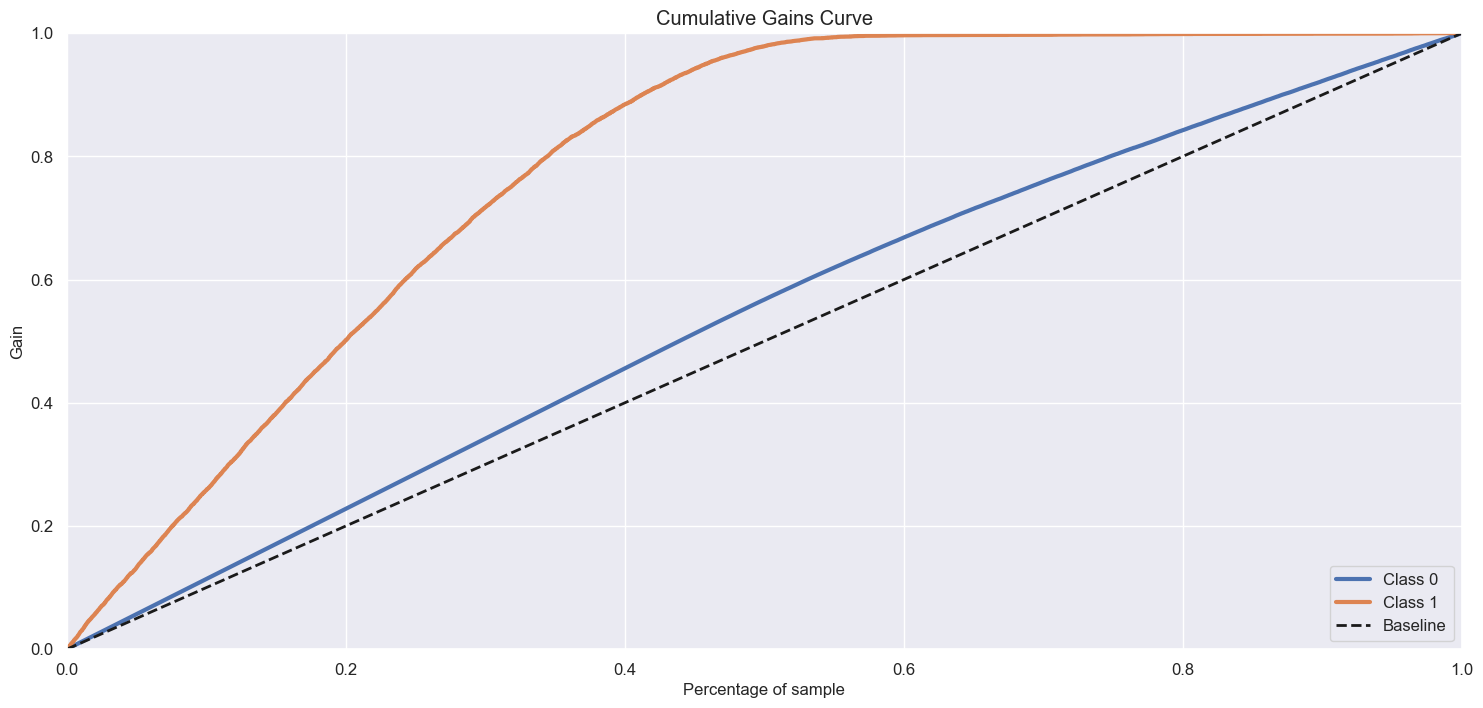

In [135]:
plot_cumulative_gain(y_val, y_hat_et_proba);

### 7.4.4. Lift Curve

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

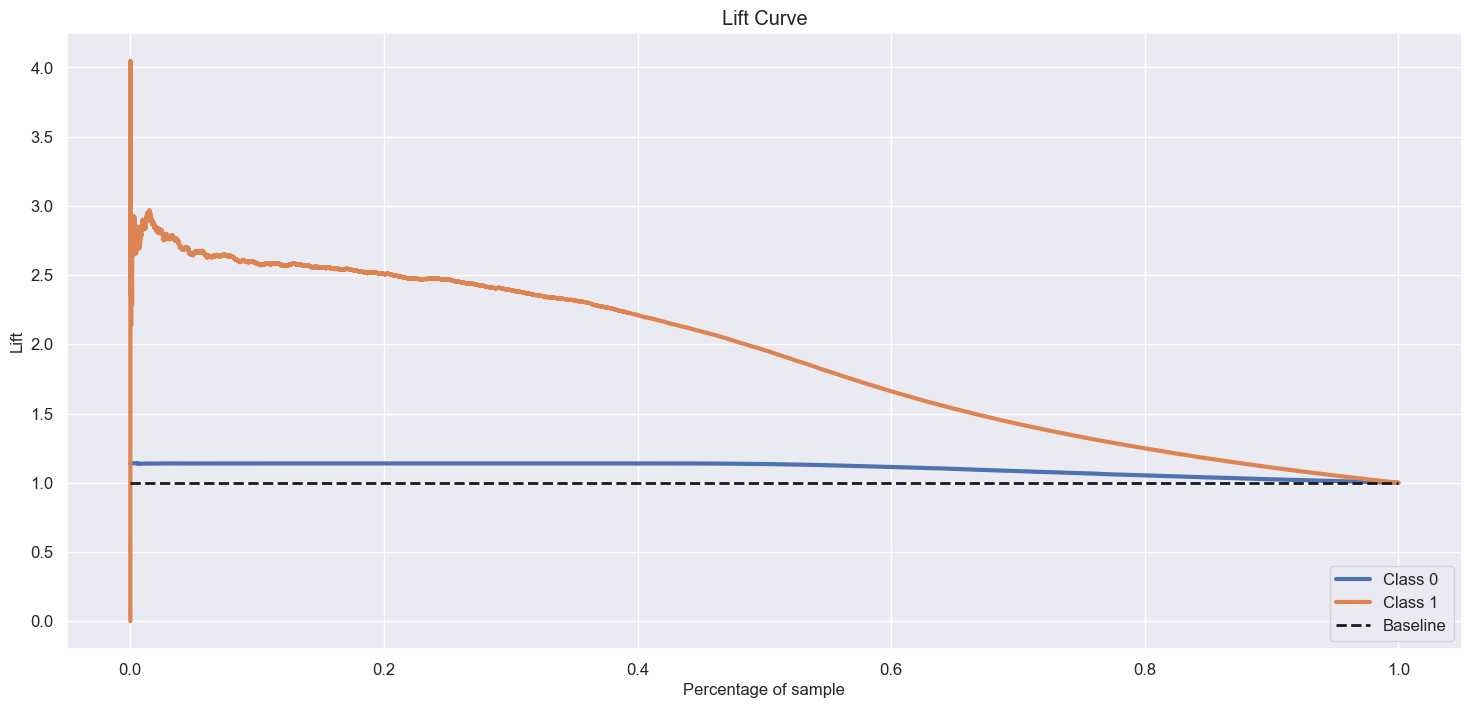

In [136]:
plot_lift_curve(y_val, y_hat_et_proba)

## 7.5. KNN

In [145]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

y_hat_knn_proba = knn.predict_proba(X_val)

### 7.5.1. Performance

In [146]:
# Compute precision and recall
performance_knn = compute_precision_recall_at_k(y_val, y_hat_knn_proba[:, 1], k=20000)
print(f'KNN - Precision@20000: {performance_knn[0]:.3f} | Recall@20000: {performance_knn[1]:.3f}')

KNN - Precision@20000: 0.420 | Recall@20000: 0.893


### 7.5.2. Cross Validation

In [144]:
# Cross Validation
knn_cross_val = cross_validation('KNN', KNeighborsClassifier(n_neighbors=5), X_train, y_train, k=20000, n_splits=5, random_state=28)
knn_cross_val

,Precision@20000,Recall@20000
KNN,0.35 +/- 0.01,0.94 +/- 0.03


### 7.5.3. Cumulative Gain Curve

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

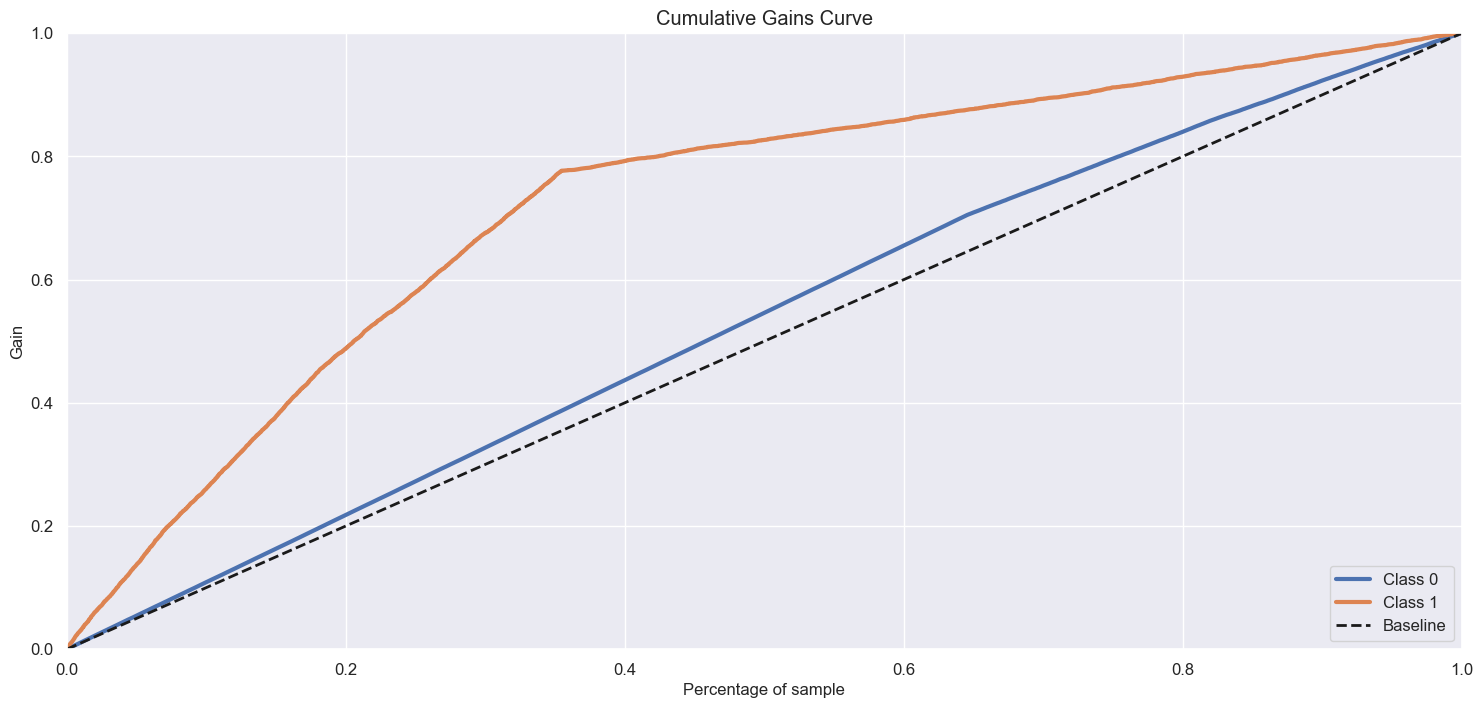

In [147]:
plot_cumulative_gain(y_val, y_hat_knn_proba)

### 7.5.4. Lift Curve

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

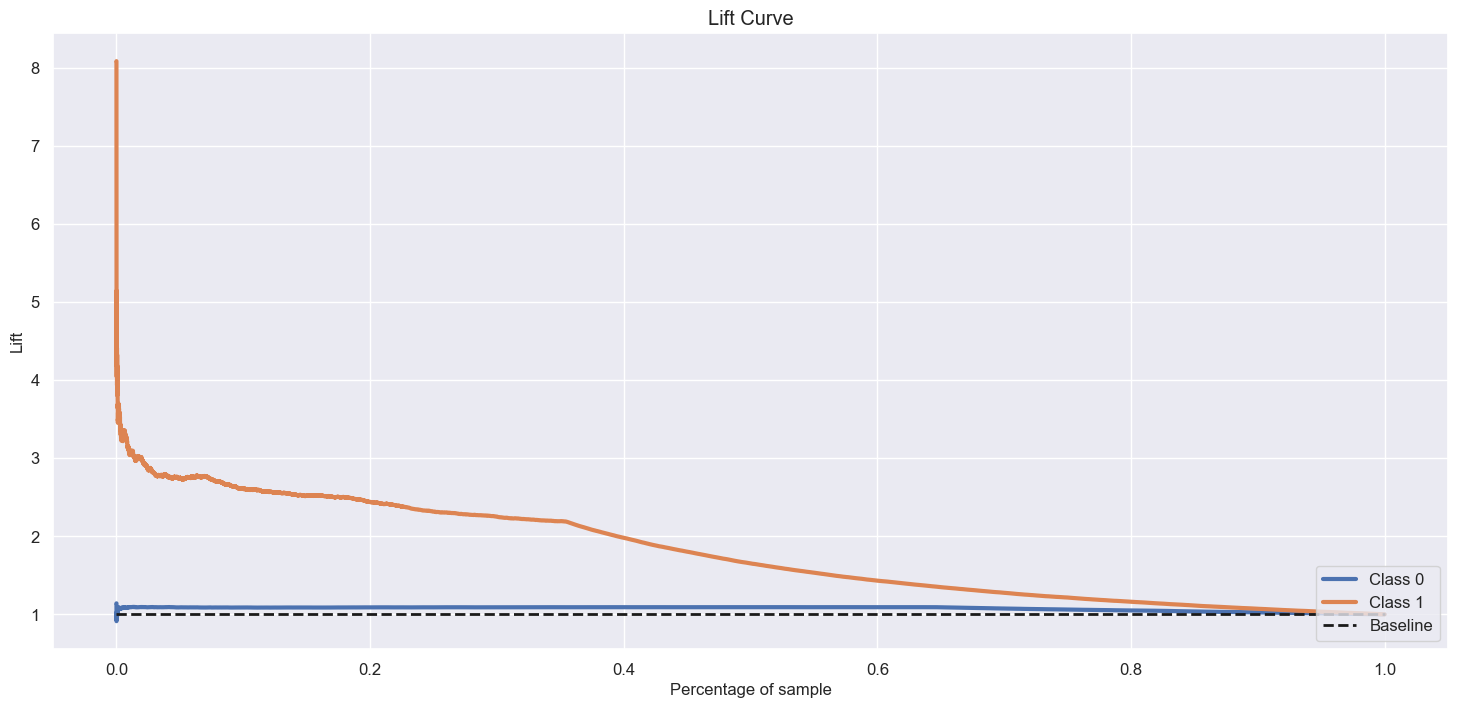

In [148]:
plot_lift_curve(y_val, y_hat_knn_proba)

## 7.6. XGBoost

In [149]:
xgb = XGBClassifier(objective='binary:logistic', verbosity=0)

xgb.fit(X_train, y_train)

y_hat_xgb_proba = xgb.predict_proba(X_val)

### 7.6.1. Performance

In [150]:
# Compute precision and recall
performance_xgb = compute_precision_recall_at_k(y_val, y_hat_xgb_proba[:, 1], k=20000)
print(f'XGB - Precision@20000: {performance_xgb[0]:.3f} | Recall@20000: {performance_xgb[1]:.3f}')

XGB - Precision@20000: 0.471 | Recall@20000: 0.999


### 7.6.2. Cross Validation

In [151]:
# Cross Validation
xgb_cross_val = cross_validation('XGB', XGBClassifier(objective='binary:logistic', verbosity=0), X_train, y_train, k=20000, n_splits=5, random_state=28)
xgb_cross_val

,Precision@20000,Recall@20000
XGB,0.31 +/- 0.07,0.84 +/- 0.19


### 7.6.3. Cumulative Gain Curve

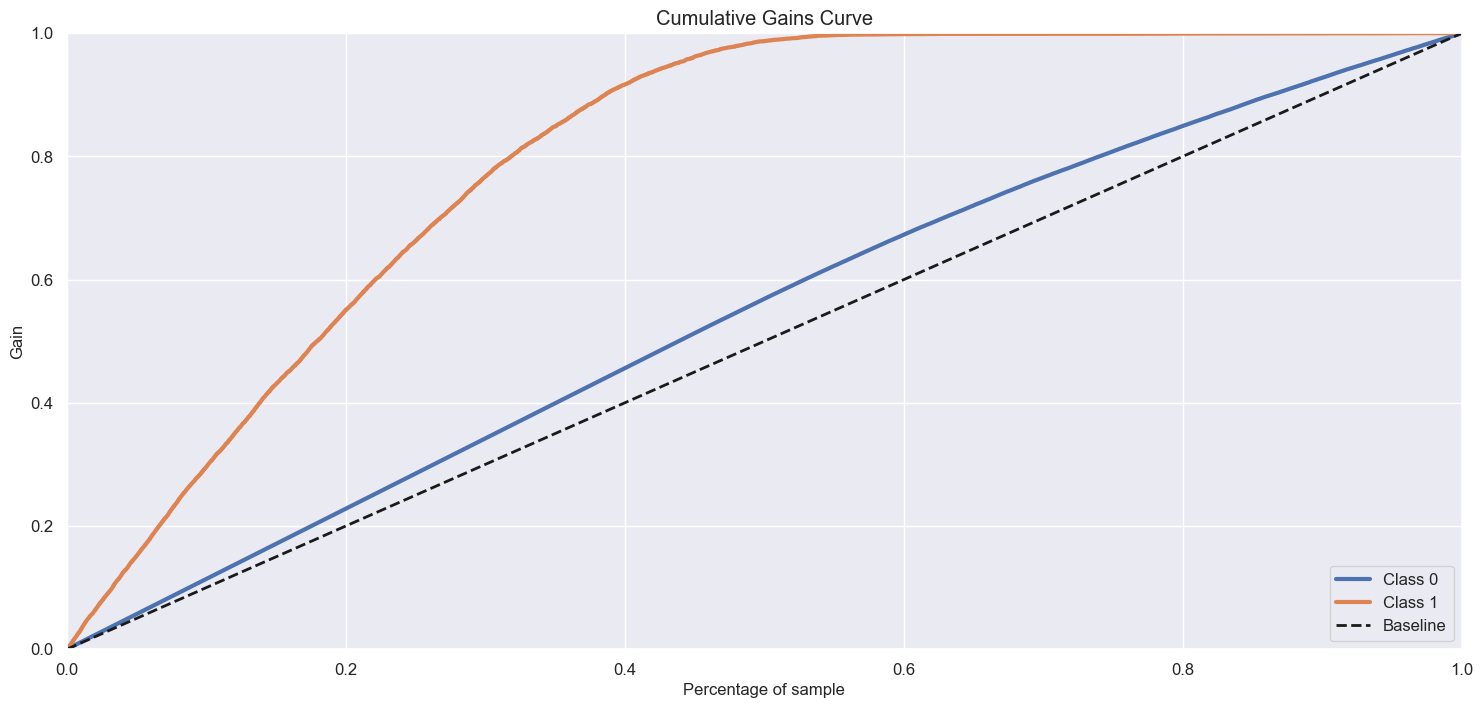

In [152]:
plot_cumulative_gain(y_val, y_hat_xgb_proba);

### 7.6.4. Lift Curve

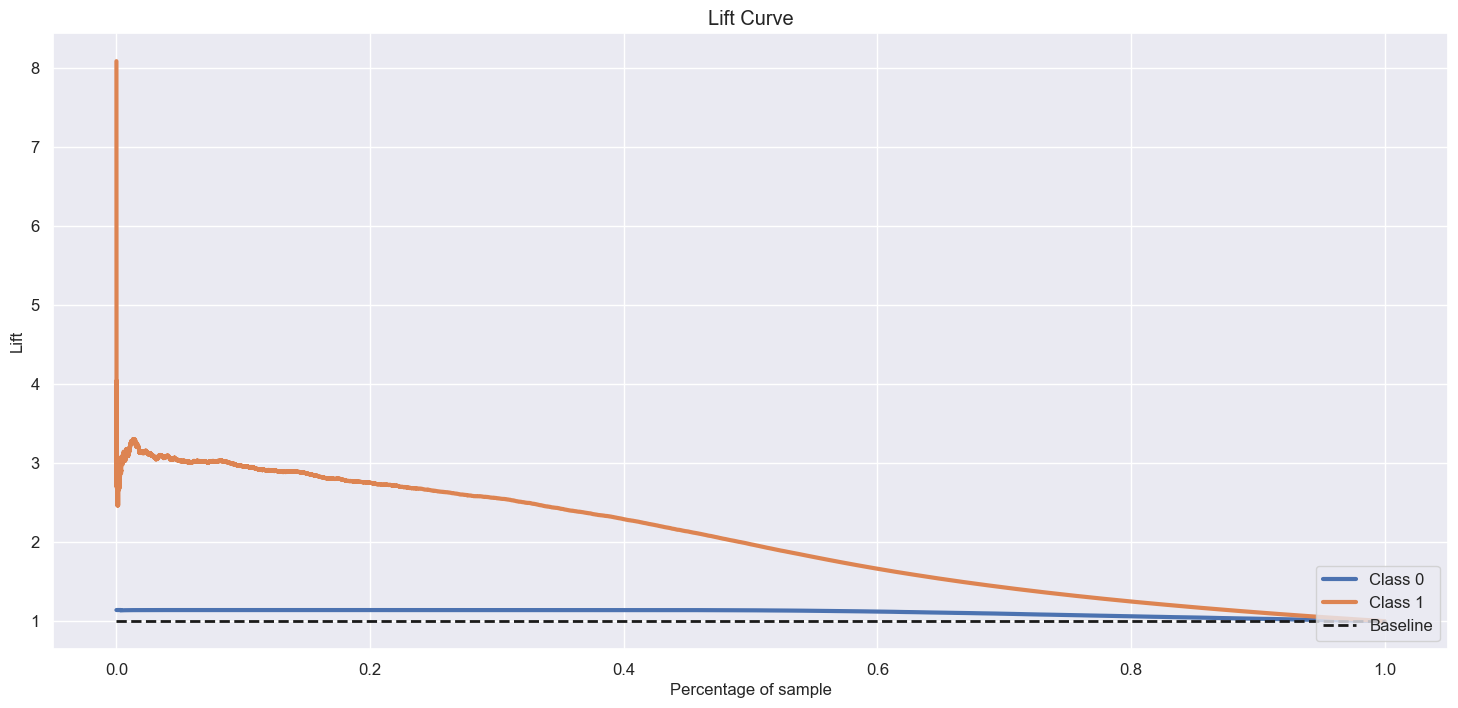

In [153]:
plot_lift_curve(y_val, y_hat_xgb_proba);

## 7.8. LGBM

In [191]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

y_hat_lgbm_proba = lgbm.predict_proba(X_val)

In [192]:
# Compute precision and recall
performance_lgbm = compute_precision_recall_at_k(y_val, y_hat_lgbm_proba[:, 1], k=20000)
print(f'XGB - Precision@20000: {performance_lgbm[0]:.3f} | Recall@20000: {performance_lgbm[1]:.3f}')

XGB - Precision@20000: 0.471 | Recall@20000: 1.000


In [193]:
# Cross Validation
lgbm_cross_val = cross_validation('LGBM', LGBMClassifier(), X_train, y_train, k=20000, n_splits=5, random_state=28)
lgbm_cross_val

,Precision@20000,Recall@20000
LGBM,0.3 +/- 0.09,0.81 +/- 0.23


## 7.9. Compare Models' Performance

### 7.9.1. Result Performance

In [200]:
df_result = pd.DataFrame(  [performance_dummy, performance_log_reg, performance_rf, performance_et, performance_knn, performance_xgb, performance_lgbm], 
                            index=["Dummy", "Logistic Regression", "Random Florest", "Extra Trees", "KNN", "XGB", "LGBM"] )
df_result.columns = ["Precision@20000", "Recall@20000"]
df_result.style.highlight_max(color='green', axis=0)

,Precision@20000,Recall@20000
Dummy,0.431350,0.915720
Logistic Regression,0.470850,0.999575
Random Florest,0.469050,0.995754
Extra Trees,0.470000,0.997771
KNN,0.420450,0.892580
XGB,0.470550,0.998939
LGBM,0.471050,1.000000


### 7.9.2. Cross Validation

In [202]:
df_result_cv = pd.concat( [log_reg_cross_val, rf_cross_val, et_cross_val, knn_cross_val, xgb_cross_val, lgbm_cross_val] )
df_result_cv.style.highlight_max(color='green', axis=0)


,Precision@20000,Recall@20000
Logistic Regression,0.23 +/- 0.13,0.61 +/- 0.36
Random Florest,0.33 +/- 0.04,0.9 +/- 0.12
Extra Trees,0.32 +/- 0.06,0.85 +/- 0.17
KNN,0.35 +/- 0.01,0.94 +/- 0.03
XGB,0.31 +/- 0.07,0.84 +/- 0.19
LGBM,0.3 +/- 0.09,0.81 +/- 0.23


# 8.0. Hyperparameter Fine Tuning

    The LGBM and KNN algorithms were defined because they were the ones with the best overall and average performance.

    To Tuning was used Hyperopt. It is a Python library for optimizing hyperparameters using Bayesian optimization. One of the advantages of Hyperopt is that it can handle complex search spaces, including conditional dependencies between hyperparameters. It also provides some advanced features, such as early stopping and parallelization.

In [212]:
from hyperopt import STATUS_OK
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import cross_val_score

## 8.1. LGBM Tuning

In [213]:
# define hyperparameters to tune
space = {
    'num_leaves': hp.choice('num_leaves', range(30, 50, 2)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.choice('n_estimators', range(50, 300, 10)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# define objective function
def objective(params):
    clf = LGBMClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

# run hyperparameter optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print('Best parameters:', best)


100%|██████████| 100/100 [15:59<00:00,  9.60s/trial, best loss: -0.8778629465169411]
Best parameters: {'colsample_bytree': 0.6760717933891838, 'learning_rate': 0.08693993919808123, 'min_child_weight': 8, 'n_estimators': 4, 'num_leaves': 6, 'reg_alpha': 0.12477612627687495, 'reg_lambda': 0.2854984894892521, 'subsample': 0.5518551478166982}


## 8.2. KNN Tuning

In [215]:
# define hyperparameters to tune
space = {
    'n_neighbors': hp.choice('n_neighbors', range(1, 21)),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'p': hp.choice('p', [1, 2])
}

# define objective function
def objective(params):
    clf = KNeighborsClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

# run hyperparameter optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print('Best parameters:', best)


100%|██████████| 100/100 [1:10:03<00:00, 42.04s/trial, best loss: -0.8745338422151994]
Best parameters: {'n_neighbors': 19, 'p': 0, 'weights': 0}


## 8.3. Best Parameters

### 8.3.1. Tuned LGBM

In [221]:
best_parameters_lgbm = { 'random_state': 28, 'colsample_bytree': 0.6760717933891838, 'learning_rate': 0.08693993919808123, 'min_child_weight': 8, 'n_estimators': 4, 'num_leaves': 6, 'reg_alpha': 0.12477612627687495, 'reg_lambda': 0.2854984894892521, 'subsample': 0.5518551478166982 }

lgbm_tuned = LGBMClassifier(**best_parameters_lgbm)
lgbm_tuned.fit(X_train, y_train)
y_hat_lgbm_proba_tuned = lgbm_tuned.predict_proba(X_val)


# Compute precision and recall
perfomance_lgbm_tuned = compute_precision_recall_at_k(y_val, y_hat_lgbm_proba_tuned[:, 1], k=20000)
print(f'LGBM TUNED - Precision@20000: {perfomance_lgbm_tuned[0]:.3f} | Recall@20000: {perfomance_lgbm_tuned[1]:.3f}')

LGBM TUNED - Precision@20000: 0.465 | Recall@20000: 0.988


### 8.3.2. Tuned KNN

In [225]:
best_parameters_knn = { 'n_neighbors': 19}

knn_tuned = KNeighborsClassifier(**best_parameters_knn)
knn_tuned.fit(X_train, y_train)
y_hat_knn_proba_tuned = knn_tuned.predict_proba(X_val)


# Compute precision and recall
perfomance_knn_tuned = compute_precision_recall_at_k(y_val, y_hat_knn_proba_tuned[:, 1], k=20000)
print(f'LGBM TUNED - Precision@20000: {perfomance_knn_tuned[0]:.3f} | Recall@20000: {perfomance_knn_tuned[1]:.3f}')

LGBM TUNED - Precision@20000: 0.465 | Recall@20000: 0.987


### 8.3.3. Results

    The LGBM Tuned model has the highest precision score and recall score, which means it has a higher accuracy in predicting true positives (precision) and has a lower chance of missing positive cases (recall) compared to the other models. This makes it a better model for binary classification problems, where identifying true positives is important.

In [229]:
df_results = pd.DataFrame(  [performance_dummy, perfomance_knn_tuned, perfomance_lgbm_tuned], 
                            index=["Dummy", "KNN Tuned", "LGBM Tuned"] )
df_results.columns = ["Precision@20000", "Recall@20000"]
df_results.style.highlight_max(color='green', axis=0)

,Precision@20000,Recall@20000
Dummy,0.431350,0.915720
KNN Tuned,0.464700,0.986519
LGBM Tuned,0.465450,0.988112
